### 4.3 모델 성능 향상을 위한 하이퍼파라미터 튜닝

#### 리눅스 환경에서 파라미터 튜닝 진행 -> ROC 그래프 한글 깨짐 현상

In [1]:
import math
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_style('white')
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
plt.rc('font', family='malgun gothic')
plt.rc('axes', unicode_minus=False)
%matplotlib inline

from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, cross_validate

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.pipeline import Pipeline

In [2]:
df = pd.read_csv('final_model.csv', encoding='cp949')
df

,기준_년_코드,역명,호선,장애인편의시설,만남의장소,현장사무소,민원안내,환승주차장,지하철이용객수,자전거보관가능대수,...,구간이동전입_3년,구간이동전출_3년,시도간이동전입_3년,시도간이동전출_3년,거주_세대_수_3년,거주인구_총계_3년,거주인구_남자_3년,거주인구_여자_3년,세대당인구_3년,고령자_65세이상_3년
0,2016,4.19민주묘지역,우이신설,0,0,0,0,0,0.829532,0.755984,...,0,0,0,1,1,0,0,0,0,1
1,2016,가락시장역,3,0,0,0,0,0,0.520235,0.919707,...,1,1,1,0,1,1,1,1,0,1
2,2016,가락시장역,8,1,0,0,0,0,0.475656,0.818231,...,1,1,1,0,1,1,1,1,0,1
3,2016,가산디지털단지역,7,1,0,0,0,0,0.889632,0.775517,...,1,1,1,1,1,1,1,1,0,1
4,2016,가양역,9,0,0,0,0,0,0.527622,0.784574,...,1,0,1,0,1,1,1,1,0,1
5,2016,가오리역,우이신설,0,0,0,0,0,0.829532,0.755984,...,0,0,0,0,1,0,0,0,0,1
6,2016,가좌역,경의중앙,0,0,0,0,0,0.498724,0.545269,...,0,0,0,0,0,0,0,0,0,0
7,2016,강남구청역,7,1,1,0,0,0,0.661191,0.610978,...,0,0,0,0,1,0,0,0,0,1
8,2016,강남역,2,1,0,0,1,0,1.000000,0.718128,...,1,1,0,0,1,1,1,1,0,1
9,2016,강동구청역,8,1,0,0,0,0,0.557457,0.930890,...,0,0,0,0,0,0,0,0,0,0


In [3]:
# 입력변수 데이터프레임과 목표변수 데이터프레임 분리
df_x, df_y = df.iloc[:,3:15], df.iloc[:,18:]
df_y_all = df_y.drop(columns=['기준_년_코드.2', '상권_변화_지표_명_1년', '상권_변화_지표_명_3년'], axis=1)

# 2017년 목표변수 데이터프레임과 2019년 목표변수 데이터프레임으로 분리
df_y_17, df_y_19 = df_y_all.iloc[:, 0:44], df_y_all.iloc[:, 44:]

### 1.1  집객 시설 수 (1년)

In [4]:
# 지출 총 금액 (2017년)
X = df_x.values
y = df_y_17.집객시설_수_1년.values

# Train, Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

In [5]:
# 하이퍼파라미터 튜닝
from sklearn.model_selection import GridSearchCV

params = {'n_estimators' :[300,400,500],
           'max_depth' : list(range(4, 20)),
           'criterion' : ['gini', 'entropy']
           }

# RandomForestClassifier 객체 생성 후 GridSearchCV 수행
rf_clf = RandomForestClassifier(random_state = 0, n_jobs = -1)
grid_cv = GridSearchCV(rf_clf, param_grid = params, cv = 5, scoring='roc_auc', n_jobs = -1)
grid_cv.fit(X_train, y_train)

print('최적 하이퍼 파라미터: ', grid_cv.best_params_)

C:\Users\pcn\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


최적 하이퍼 파라미터:  {'criterion': 'gini', 'max_depth': 6, 'n_estimators': 300}


In [6]:
# 다시 학습 및 예측 성능 측정
rf_clf1 = RandomForestClassifier(n_estimators = 400, 
                                max_depth = 4,
                                random_state = 0,
                                criterion = 'gini')
rf_clf1.fit(X_train, y_train)
y_pred = rf_clf1.predict(X_test)
print('예측 정확도: {:.4f}'.format(accuracy_score(y_test,y_pred)))

예측 정확도: 0.6733


2017년 집객시설_수_Tuning AUC = 0.6433440256615878


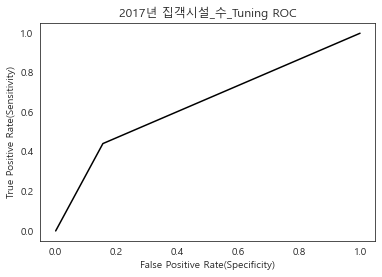

In [7]:
# Model Evaluation (AUC)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
roc_auc = metrics.auc(fpr, tpr)
print("2017년 집객시설_수_Tuning AUC =", roc_auc)

# ROC
plt.title('2017년 집객시설_수_Tuning ROC')
plt.xlabel('False Positive Rate(Specificity)')
plt.ylabel('True Positive Rate(Sensitivity)')
plt.plot(fpr, tpr, 'k', label=roc_auc); 


### 1.2 집객 시설 수 (3년)

In [8]:
# 지출 총 금액 (2019년)
X = df_x.values
y = df_y_19.집객시설_수_3년.values

# Train, Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

In [9]:
# 하이퍼파라미터 튜닝
from sklearn.model_selection import GridSearchCV

params = {'n_estimators' :[300,400,500],
           'max_depth' : list(range(4, 20)),
           'criterion' : ['gini', 'entropy']
           }

# RandomForestClassifier 객체 생성 후 GridSearchCV 수행
rf_clf = RandomForestClassifier(random_state = 0, n_jobs = -1)
grid_cv = GridSearchCV(rf_clf, param_grid = params, cv = 5,  scoring='roc_auc', n_jobs = -1)
grid_cv.fit(X_train, y_train)

print('최적 하이퍼 파라미터: ', grid_cv.best_params_)

C:\Users\pcn\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


최적 하이퍼 파라미터:  {'criterion': 'entropy', 'max_depth': 15, 'n_estimators': 500}


In [10]:
# 다시 학습 및 예측 성능 측정
rf_clf1 = RandomForestClassifier(n_estimators = 500, 
                                max_depth = 15,
                                random_state = 0,
                                criterion = 'entropy')
rf_clf1.fit(X_train, y_train)
y_pred = rf_clf1.predict(X_test)
print('예측 정확도: {:.4f}'.format(accuracy_score(y_test,y_pred)))

예측 정확도: 0.7327


2019년 집객시설_수_Tuning AUC = 0.49485930735930733


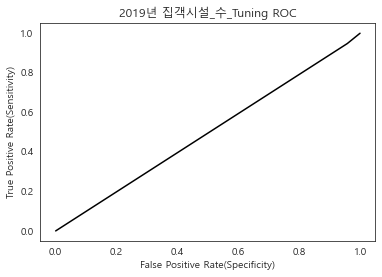

In [11]:
# Model Evaluation (AUC)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
roc_auc = metrics.auc(fpr, tpr)
print("2019년 집객시설_수_Tuning AUC =", roc_auc)

# ROC
plt.title('2019년 집객시설_수_Tuning ROC')
plt.xlabel('False Positive Rate(Specificity)')
plt.ylabel('True Positive Rate(Sensitivity)')
plt.plot(fpr, tpr, 'k', label=roc_auc); 


### 2.1 문화지출 (1년)

In [12]:
# 문화 지출 총 금액 (2017년)

X = df_x.values
y = df_y_17.문화_지출_총금액_1년.values

# Train, Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

In [13]:
#객체생성 
xgb = XGBClassifier(random_state=18)

# 하이퍼파라미터 튜닝
params = {
    'learning_rate': list(np.concatenate([np.arange(1,11)/100, np.arange(2,11)/10, np.arange(2,11)])),
    'n_iter': list(range(100, 1000, 100)),
    'max_depth': list(range(4, 20)),
    'n_estimators': list(range(100, 400,  100))
    }
           
# XGBClassifier 객체 생성 후 GridSearchCV 수행
grid_xgb = GridSearchCV(xgb, param_grid = params, n_jobs = -1, verbose=1, scoring='roc_auc')
grid_xgb.fit(X_train, y_train)

print('최적 하이퍼 파라미터: ', grid_xgb.best_params_)
print('최고 예측 정확도: {:.4f}'.format(grid_xgb.best_score_))

Fitting 3 folds for each of 12096 candidates, totalling 36288 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   37.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:  9.3min
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed: 11.0min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed: 13.5min
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed: 16.4min
[Parallel(n_jobs=-1)]: Done 6042 tasks      | elapsed: 22.4min
[Parallel(n_jobs=-1)]: Done 7192 tasks      | elapsed: 27.1min
[Parallel(n_jobs=-1)]: Done 8442 tasks      | elapsed: 31.8min
[Parallel(n_jobs=-1)]: Done 9792 tasks      | elapsed: 39.4min
[Parallel(n_jobs=-1)]: Done 11242 tasks      |

[17:06:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { n_iter } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:06:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
최적 하이퍼 파라미터:  {'learning_rate': 0.06, 'max_depth': 11, 'n_estimators': 100, 'n_iter': 100}
최고 예측 정확도: 0.6638


In [14]:
import numpy as np

In [15]:
np.concatenate([np.arange(1,11)/100, np.arange(2,11)/10, np.arange(2,11)])

array([ 0.01,  0.02,  0.03,  0.04,  0.05,  0.06,  0.07,  0.08,  0.09,
        0.1 ,  0.2 ,  0.3 ,  0.4 ,  0.5 ,  0.6 ,  0.7 ,  0.8 ,  0.9 ,
        1.  ,  2.  ,  3.  ,  4.  ,  5.  ,  6.  ,  7.  ,  8.  ,  9.  ,
       10.  ])

In [16]:
xgb1= XGBClassifier(n_estimators = 100, 
                    max_depth = 9,
                    n_iter = 100,
                    learning_rate = 0.9,
                    random_state = 18,
                    n_jobs = -1
                    )
xgb1.fit(X_train, y_train)
y_pred = xgb1.predict(X_test)
print('예측 정확도: {:.4f}'.format(accuracy_score(y_test,y_pred)))

[17:06:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { n_iter } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:06:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
예측 정확도: 0.5545


2017년 문화지출_총금액_Tuning AUC = 0.5229528535980148


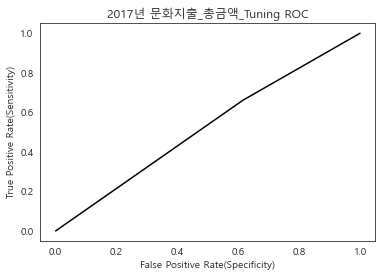

In [17]:
# Model Evaluation (AUC)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
roc_auc = metrics.auc(fpr, tpr)
print("2017년 문화지출_총금액_Tuning AUC =", roc_auc)

# ROC
plt.title('2017년 문화지출_총금액_Tuning ROC')
plt.xlabel('False Positive Rate(Specificity)')
plt.ylabel('True Positive Rate(Sensitivity)')
plt.plot(fpr, tpr, 'k', label=roc_auc); 


### 2.2 문화지출 (3년)

In [18]:
# 문화 지출 총 금액 (2019년)

X = df_x.values
y = df_y_19.문화_지출_총금액_3년.values

# Train, Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

In [19]:
#객체생성 
xgb = XGBClassifier(random_state=18)

# 하이퍼파라미터 튜닝
params = {
    'learning_rate': list(np.concatenate([np.arange(1,11)/100, np.arange(2,11)/10, np.arange(2,11)])),
    #'n_iter': list(range(100, 1000, 100)),
    'max_depth': list(range(4, 20)),
    'n_estimators': list(range(100, 400,  100))
    }
           
# XGBClassifier 객체 생성 후 GridSearchCV 수행
grid_xgb = GridSearchCV(xgb, param_grid = params, n_jobs = -1, verbose=1, scoring='roc_auc')
grid_xgb.fit(X_train, y_train)

print('최적 하이퍼 파라미터: ', grid_xgb.best_params_)
print('최고 예측 정확도: {:.4f}'.format(grid_xgb.best_score_))

Fitting 3 folds for each of 1344 candidates, totalling 4032 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  60 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 210 tasks      | elapsed:   29.8s
[Parallel(n_jobs=-1)]: Done 460 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 810 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 1260 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 1810 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 2460 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 3210 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 4032 out of 4032 | elapsed:  6.6min finished


[17:13:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
최적 하이퍼 파라미터:  {'learning_rate': 0.09, 'max_depth': 12, 'n_estimators': 100}
최고 예측 정확도: 0.6675


In [20]:
xgb1= XGBClassifier(n_estimators = 100, 
                    max_depth = 14,
                    #n_iter = 100,
                    learning_rate = 0.03,
                    random_state = 18,
                    n_jobs = -1
                    )
xgb1.fit(X_train, y_train)
y_pred = xgb1.predict(X_test)
print('예측 정확도: {:.4f}'.format(accuracy_score(y_test,y_pred)))

[17:13:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
예측 정확도: 0.6238


2019년 문화지출_총금액_Tuning AUC = 0.5490196078431373


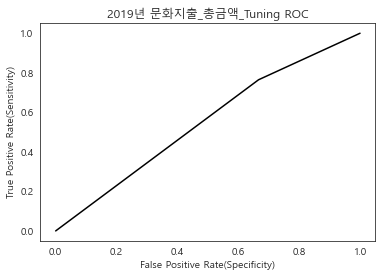

In [21]:
# Model Evaluation (AUC)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
roc_auc = metrics.auc(fpr, tpr)
print("2019년 문화지출_총금액_Tuning AUC =", roc_auc)

# ROC
plt.title('2019년 문화지출_총금액_Tuning ROC')
plt.xlabel('False Positive Rate(Specificity)')
plt.ylabel('True Positive Rate(Sensitivity)')
plt.plot(fpr, tpr, 'k', label=roc_auc); 

### 3.1 고령자 거주인구 (1년)

In [22]:
# 문화 지출 총 금액 (2017년)

X = df_x.values
y = df_y_17.고령자_65세이상_1년.values

# Train, Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

In [ ]:
#객체생성 
xgb = XGBClassifier(random_state=18)

# 하이퍼파라미터 튜닝
params = {
    'learning_rate': list(np.concatenate([np.arange(1,11)/100, np.arange(2,11)/10, np.arange(2,11)])),
    'n_iter': list(range(100, 1000, 100)),
    'max_depth': list(range(4, 20)),
    'n_estimators': list(range(100, 400,  100))
    }
           
# XGBClassifier 객체 생성 후 GridSearchCV 수행
grid_xgb = GridSearchCV(xgb, param_grid = params, n_jobs = -1, verbose=1, scoring='roc_auc')
grid_xgb.fit(X_train, y_train)

print('최적 하이퍼 파라미터: ', grid_xgb.best_params_)
print('최고 예측 정확도: {:.4f}'.format(grid_xgb.best_score_))

Fitting 3 folds for each of 12096 candidates, totalling 36288 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 230 tasks      | elapsed:   21.8s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:   58.9s


In [ ]:
xgb1= XGBClassifier(n_estimators = 300, 
                    max_depth = 8,
                    n_iter = 100,
                    learning_rate = 1.0,
                    random_state = 18,
                    n_jobs = -1
                    )
xgb1.fit(X_train, y_train)
y_pred = xgb1.predict(X_test)
print('예측 정확도: {:.4f}'.format(accuracy_score(y_test,y_pred)))

In [ ]:
# Model Evaluation (AUC)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
roc_auc = metrics.auc(fpr, tpr)
print("2017년 문화지출_총금액_Tuning AUC =", roc_auc)

# ROC
plt.title('2017년 문화지출_총금액_Tuning ROC')
plt.xlabel('False Positive Rate(Specificity)')
plt.ylabel('True Positive Rate(Sensitivity)')
plt.plot(fpr, tpr, 'k', label=roc_auc); 

### 3.2 고령자 거주인구 (3년)

In [ ]:
# 고령자 거주인구 (2019년)

X = df_x.values
y = df_y_19.고령자_65세이상_3년.values

# Train, Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

In [ ]:
#객체생성 
xgb = XGBClassifier(random_state=18)

# 하이퍼파라미터 튜닝
params = {
    'learning_rate': list(np.concatenate([np.arange(1,11)/100, np.arange(2,11)/10, np.arange(2,11)])),
    'n_iter': list(range(100, 1000, 100)),
    'max_depth': list(range(4, 20)),
    'n_estimators': list(range(100, 400,  100))
    }
           
# XGBClassifier 객체 생성 후 GridSearchCV 수행
grid_xgb = GridSearchCV(xgb, param_grid = params, n_jobs = -1, verbose=1, scoring='roc_auc')
grid_xgb.fit(X_train, y_train)

print('최적 하이퍼 파라미터: ', grid_xgb.best_params_)
print('최고 예측 정확도: {:.4f}'.format(grid_xgb.best_score_))

In [ ]:
xgb1= XGBClassifier(n_estimators = 200, 
                    max_depth = 5,
                    n_iter = 100,
                    learning_rate = 0.01,
                    random_state = 18,
                    n_jobs = -1
                   )
xgb1.fit(X_train, y_train)
y_pred = xgb1.predict(X_test)
print('예측 정확도: {:.4f}'.format(accuracy_score(y_test,y_pred)))

In [ ]:
# Model Evaluation (AUC)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
roc_auc = metrics.auc(fpr, tpr)
print("2019년_고령자거주인구_Tuning AUC =", roc_auc)

# ROC
plt.title('2019년_고령자거주인구_Tuning ROC')
plt.xlabel('False Positive Rate(Specificity)')
plt.ylabel('True Positive Rate(Sensitivity)')
plt.plot(fpr, tpr, 'k', label=roc_auc); 

### 4.1 40대 이상_직장인구 (1년)

In [ ]:
# 40대 이상_직장인구 (2017년)

X = df_x.values
y = df_y_17.연령대_40_직장_인구_수_1년.values

# Train, Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

In [ ]:
#객체생성 
xgb = XGBClassifier(random_state=18)

# 하이퍼파라미터 튜닝
params = {
    'learning_rate': list(np.concatenate([np.arange(1,11)/100, np.arange(2,11)/10, np.arange(2,11)])),
    'n_iter': list(range(100, 1000, 100)),
    'max_depth': list(range(4, 20)),
    'n_estimators': list(range(100, 400,  100))
    }
           
# XGBClassifier 객체 생성 후 GridSearchCV 수행
grid_xgb = GridSearchCV(xgb, param_grid = params, n_jobs = -1, verbose=1, scoring='roc_auc')
grid_xgb.fit(X_train, y_train)

print('최적 하이퍼 파라미터: ', grid_xgb.best_params_)
print('최고 예측 정확도: {:.4f}'.format(grid_xgb.best_score_))

In [ ]:
xgb1= XGBClassifier(n_estimators = 200, 
                    max_depth = 5,
                    n_iter = 100,
                    learning_rate = 2.0,
                    random_state = 18,
                    n_jobs = -1
                   )
xgb1.fit(X_train, y_train)
y_pred = xgb1.predict(X_test)
print('예측 정확도: {:.4f}'.format(accuracy_score(y_test,y_pred)))

In [ ]:
# Model Evaluation (AUC)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
roc_auc = metrics.auc(fpr, tpr)
print("2017년_40대이상_직장인구수_Tuning AUC =", roc_auc)

# ROC
plt.title('2017년_40대이상_직장인구수_Tuning ROC')
plt.xlabel('False Positive Rate(Specificity)')
plt.ylabel('True Positive Rate(Sensitivity)')
plt.plot(fpr, tpr, 'k', label=roc_auc); 

### 4.2 40대 이상_직장인구 (3년)

In [ ]:
# 40대 이상_직장인구 (2019년)

X = df_x.values
y = df_y_19.연령대_40_직장_인구_수_3년.values

# Train, Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

In [ ]:
#객체생성 
xgb = XGBClassifier(random_state=18)

# 하이퍼파라미터 튜닝
params = {
    'learning_rate': list(np.concatenate([np.arange(1,11)/100, np.arange(2,11)/10, np.arange(2,11)])), 
    'n_estimators': list(range(100, 400,  100)),
    'n_iter': list(range(100, 1000, 100)),
    'max_depth': list(range(4, 20)),
    }
           
# XGBClassifier 객체 생성 후 GridSearchCV 수행
grid_xgb = GridSearchCV(xgb, param_grid = params, n_jobs = -1, verbose=1, scoring='roc_auc')
grid_xgb.fit(X_train, y_train)

print('최적 하이퍼 파라미터: ', grid_xgb.best_params_)
print('최고 예측 정확도: {:.4f}'.format(grid_xgb.best_score_))

In [ ]:
xgb1= XGBClassifier(n_estimators = 300, 
                    max_depth = 7,
                    n_iter = 100,
                    learning_rate = 0.8,
                    random_state = 18,
                    n_jobs = -1
                    )
xgb1.fit(X_train, y_train)
y_pred = xgb1.predict(X_test)
print('예측 정확도: {:.4f}'.format(accuracy_score(y_test,y_pred)))

In [ ]:
# Model Evaluation (AUC)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
roc_auc = metrics.auc(fpr, tpr)
print("2019년_40대이상_직장인구수_Tuning AUC =", roc_auc)

# ROC
plt.title('2017년_40대이상_직장인구수_Tuning ROC')
plt.xlabel('False Positive Rate(Specificity)')
plt.ylabel('True Positive Rate(Sensitivity)')
plt.plot(fpr, tpr, 'k', label=roc_auc); 

### 5.1 50대 이상_직장인구  (1년)

In [ ]:
# 50대 이상_직장인구 (2017년)

X = df_x.values
y = df_y_17.연령대_50_직장_인구_수_1년.values

# Train, Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

In [ ]:
#객체생성 
xgb = XGBClassifier(random_state=18)

# 하이퍼파라미터 튜닝
params = {
    'learning_rate': list(np.concatenate([np.arange(1,11)/100, np.arange(2,11)/10, np.arange(2,11)])), 'n_estimators': list(range(100, 400,  100)),
    'n_iter': list(range(100, 1000, 100)),
    'max_depth': list(range(4, 20)),
   }
           
# XGBClassifier 객체 생성 후 GridSearchCV 수행
grid_xgb = GridSearchCV(xgb, param_grid = params, n_jobs = -1, verbose=1, scoring='roc_auc')
grid_xgb.fit(X_train, y_train)

print('최적 하이퍼 파라미터: ', grid_xgb.best_params_)
print('최고 예측 정확도: {:.4f}'.format(grid_xgb.best_score_))

In [ ]:
xgb1= XGBClassifier(n_estimators = 100 , 
                    max_depth = 9,
                    n_iter = 100,
                    learning_rate = 0.5,
                    random_state = 18,
                    n_jobs = -1
                    )
xgb1.fit(X_train, y_train)
y_pred = xgb1.predict(X_test)
print('예측 정확도: {:.4f}'.format(accuracy_score(y_test,y_pred)))

In [ ]:
# Model Evaluation (AUC)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
roc_auc = metrics.auc(fpr, tpr)
print("2017년_50대이상_직장인구수_Tuning AUC =", roc_auc)

# ROC
plt.title('2017년_50대이상_직장인구수_Tuning ROC')
plt.xlabel('False Positive Rate(Specificity)')
plt.ylabel('True Positive Rate(Sensitivity)')
plt.plot(fpr, tpr, 'k', label=roc_auc); 

### 5.2 50대 이상_직장인구  (3년)

In [ ]:
# 50대 이상_직장인구 (2019년)

X = df_x.values
y = df_y_19.연령대_50_직장_인구_수_3년.values

# Train, Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

In [ ]:
#객체생성 
xgb = XGBClassifier(random_state=18)

# 하이퍼파라미터 튜닝
params = {
    'learning_rate': list(np.concatenate([np.arange(1,11)/100, np.arange(2,11)/10, np.arange(2,11)])), 'n_estimators': list(range(100, 400,  100)),
    'n_iter': list(range(100, 1000, 100)),
    'max_depth': list(range(4, 20)),
    }
           
# XGBClassifier 객체 생성 후 GridSearchCV 수행
grid_xgb = GridSearchCV(xgb, param_grid = params, n_jobs = -1, verbose=1, scoring='roc_auc')
grid_xgb.fit(X_train, y_train)

print('최적 하이퍼 파라미터: ', grid_xgb.best_params_)
print('최고 예측 정확도: {:.4f}'.format(grid_xgb.best_score_))

In [ ]:
xgb1= XGBClassifier(n_estimators = 100, 
                    max_depth = 9,
                    n_iter = 100,
                    learning_rate = 5.0,
                    random_state = 18,
                    n_jobs = -1
                    )
xgb1.fit(X_train, y_train)
y_pred = xgb1.predict(X_test)
print('예측 정확도: {:.4f}'.format(accuracy_score(y_test,y_pred)))

In [ ]:
# Model Evaluation (AUC)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
roc_auc = metrics.auc(fpr, tpr)
print("2019년_50대이상_직장인구수_Tuning AUC =", roc_auc)

# ROC
plt.title('2019년_50대이상_직장인구수_Tuning ROC')
plt.xlabel('False Positive Rate(Specificity)')
plt.ylabel('True Positive Rate(Sensitivity)')
plt.plot(fpr, tpr, 'k', label=roc_auc); 

### 6.1 60대이상_직장인구 수 (1년)

In [ ]:
# 60대 이상_직장인구 (2017년)

X = df_x.values
y = df_y_17.연령대_60_이상_직장_인구_수_1년.values

# Train, Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

In [ ]:
# 하이퍼파라미터 튜닝
from sklearn.model_selection import GridSearchCV

params = {'n_estimators' :[300,400,500],
           'max_depth' : list(range(4, 20)),
           'criterion' : ['gini', 'entropy']
           }

# RandomForestClassifier 객체 생성 후 GridSearchCV 수행
rf_clf = RandomForestClassifier(random_state = 0, n_jobs = -1)
grid_cv = GridSearchCV(rf_clf, param_grid = params, scoring='roc_auc', cv = 5, n_jobs = -1)
grid_cv.fit(X_train, y_train)

print('최적 하이퍼 파라미터: ', grid_cv.best_params_)

In [ ]:
# 다시 학습 및 예측 성능 측정
rf_clf1 = RandomForestClassifier(n_estimators = 300, 
                                max_depth = 17,
                                random_state = 1,
                                criterion = 'entropy')
rf_clf1.fit(X_train, y_train)
y_pred = rf_clf1.predict(X_test)
print('예측 정확도: {:.4f}'.format(accuracy_score(y_test,y_pred)))

In [ ]:
# Model Evaluation (AUC)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
roc_auc = metrics.auc(fpr, tpr)
print("2017년_60대이상_직장인구수_Tuning AUC =", roc_auc)

# ROC
plt.title('2017년_60대이상_직장인구수_Tuning ROC')
plt.xlabel('False Positive Rate(Specificity)')
plt.ylabel('True Positive Rate(Sensitivity)')
plt.plot(fpr, tpr, 'k', label=roc_auc); 

### 6.2 60대이상_직장인구 수 (3년)

In [ ]:
# 60대 이상_직장인구 (2019년)

X = df_x.values
y = df_y_19.연령대_60_이상_직장_인구_수_3년.values

# Train, Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

In [ ]:
# 하이퍼파라미터 튜닝
from sklearn.model_selection import GridSearchCV

params = {'n_estimators' :[300,400,500],
           'max_depth' : list(range(4, 20)),
           'criterion' : ['gini', 'entropy']
           }

# RandomForestClassifier 객체 생성 후 GridSearchCV 수행
rf_clf = RandomForestClassifier(random_state = 0, n_jobs = -1)
grid_cv = GridSearchCV(rf_clf, param_grid = params, scoring='roc_auc', cv = 5, n_jobs = -1)
grid_cv.fit(X_train, y_train)

print('최적 하이퍼 파라미터: ', grid_cv.best_params_)

In [ ]:
# 다시 학습 및 예측 성능 측정
rf_clf1 = RandomForestClassifier(n_estimators = 400, 
                                max_depth = 6,
                                random_state = 1,
                                criterion = 'gini')
rf_clf1.fit(X_train, y_train)
y_pred = rf_clf1.predict(X_test)
print('예측 정확도: {:.4f}'.format(accuracy_score(y_test,y_pred)))

In [ ]:
# Model Evaluation (AUC)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
roc_auc = metrics.auc(fpr, tpr)
print("2019년_60대이상_직장인구수_Tuning AUC =", roc_auc)

# ROC
plt.title('2019년_60대이상_직장인구수_Tuning ROC')
plt.xlabel('False Positive Rate(Specificity)')
plt.ylabel('True Positive Rate(Sensitivity)')
plt.plot(fpr, tpr, 'k', label=roc_auc); 

### 7.1 연립주택 가격 (1년)

In [ ]:
# 연립주택 가격  (2017년)

X = df_x.values
y = df_y_17.연립주택_가격_1년.values

# Train, Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

In [ ]:
#객체생성 
xgb = XGBClassifier(random_state=18)

# 하이퍼파라미터 튜닝
params = {
    'learning_rate': list(np.concatenate([np.arange(1,11)/100, np.arange(2,11)/10, np.arange(2,11)])), 'n_estimators': list(range(100, 400,  100)),
    'n_iter': list(range(100, 1000, 100)),
    'max_depth': list(range(4, 20)),
    }
           
# XGBClassifier 객체 생성 후 GridSearchCV 수행
grid_xgb = GridSearchCV(xgb, param_grid = params, n_jobs = -1, verbose=1, scoring='roc_auc')
grid_xgb.fit(X_train, y_train)

print('최적 하이퍼 파라미터: ', grid_xgb.best_params_)
print('최고 예측 정확도: {:.4f}'.format(grid_xgb.best_score_))

In [ ]:
xgb1= XGBClassifier(n_estimators = 200, 
                    max_depth = 6,
                    n_iter = 100,
                    learning_rate = 3.0,
                    random_state = 18,
                    n_jobs = -1
                    )
xgb1.fit(X_train, y_train)
y_pred = xgb1.predict(X_test)
print('예측 정확도: {:.4f}'.format(accuracy_score(y_test,y_pred)))

In [ ]:
# Model Evaluation (AUC)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
roc_auc = metrics.auc(fpr, tpr)
print("2017년_연립주택 가격_Tuning AUC =", roc_auc)

# ROC
plt.title('2017년_연립주택가격_Tuning ROC')
plt.xlabel('False Positive Rate(Specificity)')
plt.ylabel('True Positive Rate(Sensitivity)')
plt.plot(fpr, tpr, 'k', label=roc_auc); 

### 7.2 연립주택가격 (3년)

In [ ]:
# 연립주택 가격  (2019년)

X = df_x.values
y = df_y_19.연립주택_가격_3년.values

# Train, Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

In [ ]:
#객체생성 
xgb = XGBClassifier(random_state=18)

# 하이퍼파라미터 튜닝
params = {
    'learning_rate': list(np.concatenate([np.arange(1,11)/100, np.arange(2,11)/10, np.arange(2,11)])), 'n_estimators': list(range(100, 400,  100)),
    'n_iter': list(range(100, 1000, 100)),
    'max_depth': list(range(4, 20)),
    }
           
# XGBClassifier 객체 생성 후 GridSearchCV 수행
grid_xgb = GridSearchCV(xgb, param_grid = params, n_jobs = -1, verbose=1, scoring='roc_auc')
grid_xgb.fit(X_train, y_train)

print('최적 하이퍼 파라미터: ', grid_xgb.best_params_)
print('최고 예측 정확도: {:.4f}'.format(grid_xgb.best_score_))

In [ ]:
xgb1= XGBClassifier(n_estimators = 300, 
                    max_depth = 5,
                    n_iter = 100,
                    learning_rate = 0.03,
                    random_state = 18,
                    n_jobs = -1
                    )
xgb1.fit(X_train, y_train)
y_pred = xgb1.predict(X_test)
print('예측 정확도: {:.4f}'.format(accuracy_score(y_test,y_pred)))

In [ ]:
# Model Evaluation (AUC)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
roc_auc = metrics.auc(fpr, tpr)
print("2019년_연립주택 가격_Tuning AUC =", roc_auc)

# ROC
plt.title('2019년_연립주택가격_Tuning ROC')
plt.xlabel('False Positive Rate(Specificity)')
plt.ylabel('True Positive Rate(Sensitivity)')
plt.plot(fpr, tpr, 'k', label=roc_auc); 

### 8.1 아파트 가격 (1년)

In [ ]:
# 아파트가격 (2017년)

X = df_x.values
y = df_y_17.아파트_가격_1년.values

# Train, Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

In [73]:
#객체생성 
xgb = XGBClassifier(random_state=18)

# 하이퍼파라미터 튜닝
params = {
    'learning_rate': list(np.concatenate([np.arange(1,11)/100, np.arange(2,11)/10, np.arange(2,11)])), 'n_estimators': list(range(100, 400,  100)),
    'n_iter': list(range(100, 1000, 100)),
    'max_depth': list(range(4, 20)),
    }
           
# XGBClassifier 객체 생성 후 GridSearchCV 수행
grid_xgb = GridSearchCV(xgb, param_grid = params, n_jobs = -1, verbose=1, scoring='roc_auc')
grid_xgb.fit(X_train, y_train)

print('최적 하이퍼 파라미터: ', grid_xgb.best_params_)
print('최고 예측 정확도: {:.4f}'.format(grid_xgb.best_score_))

Fitting 5 folds for each of 12096 candidates, totalling 60480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 648 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 3200 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 6800 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 11200 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done 16400 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done 22400 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done 29200 tasks      | elapsed:   20.3s
[Parallel(n_jobs=-1)]: Done 36800 tasks      | elapsed:   24.3s
[Parallel(n_jobs=-1)]: Done 45200 tasks      | elapsed:   28.3s
[Parallel(n_jobs=-1)]: Done 54400 tasks      | elapsed:   32.1s


[13:46:21] WARNING: ../src/learner.cc:516: 
Parameters: { n_iter } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


최적 하이퍼 파라미터:  {'learning_rate': 0.6, 'max_depth': 5, 'n_estimators': 100, 'n_iter': 100}
최고 예측 정확도: 0.7057


[Parallel(n_jobs=-1)]: Done 60480 out of 60480 | elapsed:   34.4s finished


In [77]:
xgb1= XGBClassifier(n_estimators = 100 ,
                    max_depth = 5,
                    n_iter = 100,
                    learning_rate = 0.6,
                    random_state = 18,
                    n_jobs = -1
                    )
xgb1.fit(X_train, y_train)
y_pred = xgb1.predict(X_test)
print('예측 정확도: {:.4f}'.format(accuracy_score(y_test,y_pred)))

[13:47:23] WARNING: ../src/learner.cc:516: 
Parameters: { n_iter } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


예측 정확도: 0.9010


2019년_연립주택 가격_Tuning AUC = 0.7465034965034966


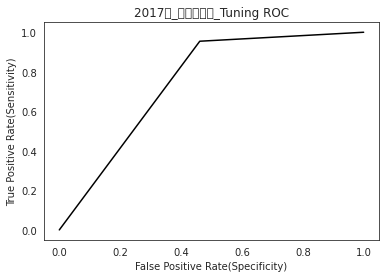

In [78]:
# Model Evaluation (AUC)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
roc_auc = metrics.auc(fpr, tpr)
print("2019년_연립주택 가격_Tuning AUC =", roc_auc)

# ROC
plt.title('2017년_아파트가격_Tuning ROC')
plt.xlabel('False Positive Rate(Specificity)')
plt.ylabel('True Positive Rate(Sensitivity)')
plt.plot(fpr, tpr, 'k', label=roc_auc); 

### 8.2 아파트 가격 (3년)

In [79]:
# 아파트가격 (2019년)

X = df_x.values
y = df_y_19.아파트_가격_3년.values

# Train, Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

In [80]:
#객체생성 
xgb = XGBClassifier(random_state=18)

# 하이퍼파라미터 튜닝
params = {
    'learning_rate': list(np.concatenate([np.arange(1,11)/100, np.arange(2,11)/10, np.arange(2,11)])), 'n_estimators': list(range(100, 400,  100)),
    'n_iter': list(range(100, 1000, 100)),
    'max_depth': list(range(4, 20)),
    }
           
# XGBClassifier 객체 생성 후 GridSearchCV 수행
grid_xgb = GridSearchCV(xgb, param_grid = params, n_jobs = -1, verbose=1, scoring='roc_auc')
grid_xgb.fit(X_train, y_train)

print('최적 하이퍼 파라미터: ', grid_xgb.best_params_)
print('최고 예측 정확도: {:.4f}'.format(grid_xgb.best_score_))

Fitting 5 folds for each of 12096 candidates, totalling 60480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 648 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 3200 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 6800 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 11200 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 16400 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done 22400 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done 29200 tasks      | elapsed:   18.4s
[Parallel(n_jobs=-1)]: Done 36800 tasks      | elapsed:   22.4s
[Parallel(n_jobs=-1)]: Done 45200 tasks      | elapsed:   26.3s
[Parallel(n_jobs=-1)]: Done 54400 tasks      | elapsed:   30.2s


[13:48:06] WARNING: ../src/learner.cc:516: 
Parameters: { n_iter } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


최적 하이퍼 파라미터:  {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 300, 'n_iter': 100}
최고 예측 정확도: 0.7902


[Parallel(n_jobs=-1)]: Done 60480 out of 60480 | elapsed:   32.6s finished


In [81]:
xgb1= XGBClassifier(n_estimators = 300, 
                    max_depth = 5,
                    n_iter = 100,
                    learning_rate = 0.01,
                    random_state = 18,
                    n_jobs = -1
                    )
xgb1.fit(X_train, y_train)
y_pred = xgb1.predict(X_test)
print('예측 정확도: {:.4f}'.format(accuracy_score(y_test,y_pred)))

[13:48:28] WARNING: ../src/learner.cc:516: 
Parameters: { n_iter } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


예측 정확도: 0.8911


2019년_연립주택 가격_Tuning AUC = 0.6858614232209738


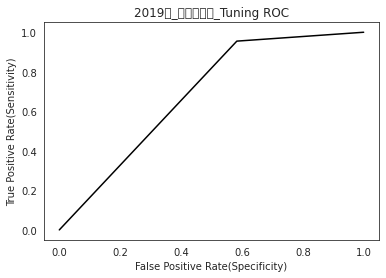

In [82]:
# Model Evaluation (AUC)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
roc_auc = metrics.auc(fpr, tpr)
print("2019년_연립주택 가격_Tuning AUC =", roc_auc)

# ROC
plt.title('2019년_아파트가격_Tuning ROC')
plt.xlabel('False Positive Rate(Specificity)')
plt.ylabel('True Positive Rate(Sensitivity)')
plt.plot(fpr, tpr, 'k', label=roc_auc); 

### 9.1 아파트 면적 (1년)

In [90]:
# 아파트 면적  (2017년)
X = df_x.values
y = df_y_17.아파트_면적_1년.values

# Train, Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

In [91]:
# 하이퍼파라미터 튜닝
from sklearn.model_selection import GridSearchCV

params = {'n_estimators' :[300,400,500],
           'max_depth' : list(range(4, 20)),
           'criterion' : ['gini', 'entropy']
           }

# RandomForestClassifier 객체 생성 후 GridSearchCV 수행
rf_clf = RandomForestClassifier(random_state = 0, n_jobs = -1)
grid_cv = GridSearchCV(rf_clf, param_grid = params, scoring='roc_auc', cv = 5, n_jobs = -1)
grid_cv.fit(X_train, y_train)

print('최적 하이퍼 파라미터: ', grid_cv.best_params_)

최적 하이퍼 파라미터:  {'criterion': 'gini', 'max_depth': 12, 'n_estimators': 300}


In [92]:
# 다시 학습 및 예측 성능 측정
rf_clf1 = RandomForestClassifier(n_estimators = 300, 
                                max_depth = 12,
                                random_state = 1,
                                criterion = 'gini')
rf_clf1.fit(X_train, y_train)
y_pred = rf_clf1.predict(X_test)
print('예측 정확도: {:.4f}'.format(accuracy_score(y_test,y_pred)))

예측 정확도: 0.6634


2017년 아파트_면적_Tuning AUC = 0.6152882205513784


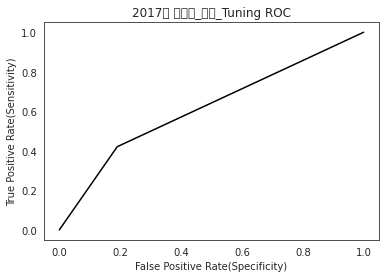

In [93]:
# Model Evaluation (AUC)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
roc_auc = metrics.auc(fpr, tpr)
print("2017년 아파트_면적_Tuning AUC =", roc_auc)

# ROC
plt.title('2017년 아파트_면적_Tuning ROC')
plt.xlabel('False Positive Rate(Specificity)')
plt.ylabel('True Positive Rate(Sensitivity)')
plt.plot(fpr, tpr, 'k', label=roc_auc); 


### 9.2 아파트 면적 (3년)

In [94]:
# 아파트 면적  (2019년)
X = df_x.values
y = df_y_19.아파트_면적_3년.values

# Train, Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

In [97]:
#객체생성 
xgb = XGBClassifier(random_state=18)

# 하이퍼파라미터 튜닝
params = {
    'learning_rate': list(np.concatenate([np.arange(1,11)/100, np.arange(2,11)/10, np.arange(2,11)])), 'n_estimators': list(range(100, 400,  100)),
    'n_iter': list(range(100, 1000, 100)),
    'max_depth': list(range(4, 20)),
    }
           
# XGBClassifier 객체 생성 후 GridSearchCV 수행
grid_xgb = GridSearchCV(xgb, param_grid = params, n_jobs = -1, verbose=1, scoring='roc_auc')
grid_xgb.fit(X_train, y_train)

print('최적 하이퍼 파라미터: ', grid_xgb.best_params_)
print('최고 예측 정확도: {:.4f}'.format(grid_xgb.best_score_))

Fitting 5 folds for each of 12096 candidates, totalling 60480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 648 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 2048 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 3848 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 6048 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 8648 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done 11648 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done 15048 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done 18848 tasks      | elapsed:   17.2s
[Parallel(n_jobs=-1)]: Done 23048 tasks      | elapsed:   20.5s
[Parallel(n_jobs=-1)]: Done 27648 tasks      | elapsed:   23.8s
[Parallel(n_jobs=-1)]: Done 32648 tasks      | elapsed:   27.2s
[Parallel(n_jobs=-1)]: Done 38048 tasks      | elapsed:   30.5s
[Parallel(n_jobs=-1)]: Done 43848 tasks      | elapsed:   33.8s
[Parallel(n_jobs=-1)]: Done 55680 t

[13:53:37] WARNING: ../src/learner.cc:516: 
Parameters: { n_iter } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


최적 하이퍼 파라미터:  {'learning_rate': 6.0, 'max_depth': 4, 'n_estimators': 300, 'n_iter': 100}
최고 예측 정확도: 0.6411


[Parallel(n_jobs=-1)]: Done 60480 out of 60480 | elapsed:   40.6s finished


In [98]:
xgb1= XGBClassifier(n_estimators = 300, 
                    max_depth = 4,
                    n_iter = 100,
                    learning_rate = 6.0,
                    random_state = 18,
                    n_jobs = -1
                    )
xgb1.fit(X_train, y_train)
y_pred = xgb1.predict(X_test)
print('예측 정확도: {:.4f}'.format(accuracy_score(y_test,y_pred)))

[13:53:58] WARNING: ../src/learner.cc:516: 
Parameters: { n_iter } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


예측 정확도: 0.6535


2019년 아파트_면적_Tuning AUC = 0.5580246913580247


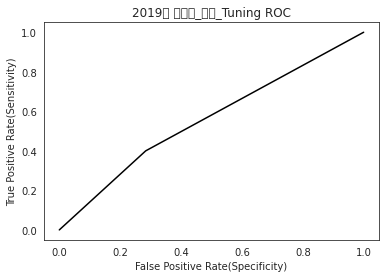

In [99]:
# Model Evaluation (AUC)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
roc_auc = metrics.auc(fpr, tpr)
print("2019년 아파트_면적_Tuning AUC =", roc_auc)

# ROC
plt.title('2019년 아파트_면적_Tuning ROC')
plt.xlabel('False Positive Rate(Specificity)')
plt.ylabel('True Positive Rate(Sensitivity)')
plt.plot(fpr, tpr, 'k', label=roc_auc); 


### 10.1 총직장인구 (1년)

In [100]:
# 총 직장인구 수  (2017년)
X = df_x.values
y = df_y_17.총_직장_인구_수_1년.values

# Train, Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

In [101]:
# 하이퍼파라미터 튜닝
from sklearn.model_selection import GridSearchCV

params = {'n_estimators' :[300,400,500],
           'max_depth' : list(range(4, 20)),
           'criterion' : ['gini', 'entropy']
           }

# RandomForestClassifier 객체 생성 후 GridSearchCV 수행
rf_clf = RandomForestClassifier(random_state = 0, n_jobs = -1)
grid_cv = GridSearchCV(rf_clf, param_grid = params, scoring='roc_auc', cv = 5, n_jobs = -1)
grid_cv.fit(X_train, y_train)

print('최적 하이퍼 파라미터: ', grid_cv.best_params_)

최적 하이퍼 파라미터:  {'criterion': 'entropy', 'max_depth': 5, 'n_estimators': 300}


In [102]:
# 다시 학습 및 예측 성능 측정
rf_clf1 = RandomForestClassifier(n_estimators = 300, 
                                max_depth = 5,
                                random_state = 1,
                                criterion = 'entropy')
rf_clf1.fit(X_train, y_train)
y_pred = rf_clf1.predict(X_test)
print('예측 정확도: {:.4f}'.format(accuracy_score(y_test,y_pred)))

예측 정확도: 0.6238


2017년 총직장 인구 수_Tuning AUC = 0.6240188383045526


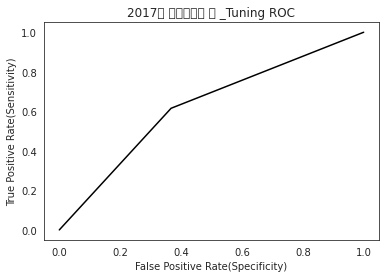

In [103]:
# Model Evaluation (AUC)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
roc_auc = metrics.auc(fpr, tpr)
print("2017년 총직장 인구 수_Tuning AUC =", roc_auc)

# ROC
plt.title('2017년 총직장인구 수 _Tuning ROC')
plt.xlabel('False Positive Rate(Specificity)')
plt.ylabel('True Positive Rate(Sensitivity)')
plt.plot(fpr, tpr, 'k', label=roc_auc); 


### 10.2  총직장인구 (3년)

In [104]:
# 총직장 인구 수  (2019년)
X = df_x.values
y = df_y_19.총_직장_인구_수_3년.values

# Train, Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

In [109]:
#객체생성 
xgb = XGBClassifier(random_state=18)

# 하이퍼파라미터 튜닝
params = {
    'learning_rate': list(np.concatenate([np.arange(1,11)/100, np.arange(2,11)/10, np.arange(2,11)])), 'n_estimators': list(range(100, 400,  100)),
    'n_iter': list(range(100, 1000, 100)),
    'max_depth': list(range(4, 20)),
    }
           
# XGBClassifier 객체 생성 후 GridSearchCV 수행
grid_xgb = GridSearchCV(xgb, param_grid = params, n_jobs = -1, verbose=1, scoring='roc_auc')
grid_xgb.fit(X_train, y_train)

print('최적 하이퍼 파라미터: ', grid_xgb.best_params_)
print('최고 예측 정확도: {:.4f}'.format(grid_xgb.best_score_))

Fitting 5 folds for each of 12096 candidates, totalling 60480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 648 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 3200 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 6800 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 11200 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done 16400 tasks      | elapsed:   16.4s
[Parallel(n_jobs=-1)]: Done 22400 tasks      | elapsed:   21.5s
[Parallel(n_jobs=-1)]: Done 29200 tasks      | elapsed:   26.7s
[Parallel(n_jobs=-1)]: Done 36800 tasks      | elapsed:   32.0s
[Parallel(n_jobs=-1)]: Done 45200 tasks      | elapsed:   36.7s
[Parallel(n_jobs=-1)]: Done 54400 tasks      | elapsed:   40.7s


[13:59:50] WARNING: ../src/learner.cc:516: 
Parameters: { n_iter } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


최적 하이퍼 파라미터:  {'learning_rate': 7.0, 'max_depth': 9, 'n_estimators': 100, 'n_iter': 100}
최고 예측 정확도: 0.5621


[Parallel(n_jobs=-1)]: Done 60480 out of 60480 | elapsed:   43.0s finished


In [110]:
xgb1= XGBClassifier(n_estimators = 100, 
                    max_depth = 9,
                    n_iter = 100,
                    learning_rate = 7.0,
                    random_state = 18,
                    n_jobs = -1
                    )
xgb1.fit(X_train, y_train)
y_pred = xgb1.predict(X_test)
print('예측 정확도: {:.4f}'.format(accuracy_score(y_test,y_pred)))

[14:00:00] WARNING: ../src/learner.cc:516: 
Parameters: { n_iter } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


예측 정확도: 0.4455


2019년 총직장 인구 수_Tuning AUC = 0.4029671210906175


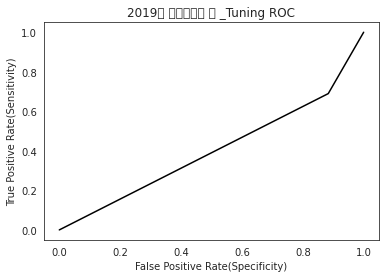

In [111]:
# Model Evaluation (AUC)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
roc_auc = metrics.auc(fpr, tpr)
print("2019년 총직장 인구 수_Tuning AUC =", roc_auc)

# ROC
plt.title('2019년 총직장인구 수 _Tuning ROC')
plt.xlabel('False Positive Rate(Specificity)')
plt.ylabel('True Positive Rate(Sensitivity)')
plt.plot(fpr, tpr, 'k', label=roc_auc); 


### 11.1 여성 직장인 수 (1년 )

In [112]:
# 여성 직장인구 수  (2017년)
X = df_x.values
y = df_y_17.여성_직장_인구_수_1년.values

# Train, Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

In [113]:
# 하이퍼파라미터 튜닝
from sklearn.model_selection import GridSearchCV

params = {'n_estimators' :[300,400,500],
           'max_depth' : list(range(4, 20)),
           'criterion' : ['gini', 'entropy']
           }

# RandomForestClassifier 객체 생성 후 GridSearchCV 수행
rf_clf = RandomForestClassifier(random_state = 0, n_jobs = -1)
grid_cv = GridSearchCV(rf_clf, param_grid = params, scoring='roc_auc', cv = 5, n_jobs = -1)
grid_cv.fit(X_train, y_train)

print('최적 하이퍼 파라미터: ', grid_cv.best_params_)

최적 하이퍼 파라미터:  {'criterion': 'gini', 'max_depth': 17, 'n_estimators': 300}


In [114]:
# 다시 학습 및 예측 성능 측정
rf_clf1 = RandomForestClassifier(n_estimators = 300, 
                                max_depth = 17,
                                random_state = 1,
                                criterion = 'gini')
rf_clf1.fit(X_train, y_train)
y_pred = rf_clf1.predict(X_test)
print('예측 정확도: {:.4f}'.format(accuracy_score(y_test,y_pred)))

예측 정확도: 0.5743


2017년 여성 직장인구 수_Tuning AUC = 0.5673758865248226


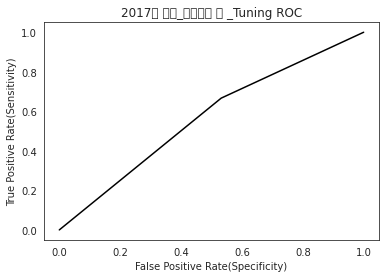

In [115]:
# Model Evaluation (AUC)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
roc_auc = metrics.auc(fpr, tpr)
print("2017년 여성 직장인구 수_Tuning AUC =", roc_auc)

# ROC
plt.title('2017년 여성_직장인구 수 _Tuning ROC')
plt.xlabel('False Positive Rate(Specificity)')
plt.ylabel('True Positive Rate(Sensitivity)')
plt.plot(fpr, tpr, 'k', label=roc_auc); 


### 11.2 여성직장인 수 (3년)

In [116]:
# 여성직장인구 수 (2019년)
X = df_x.values
y = df_y_19.여성_직장_인구_수_3년.values

# Train, Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

In [117]:
# 하이퍼파라미터 튜닝
from sklearn.model_selection import GridSearchCV

params = {'n_estimators' :[300,400,500],
           'max_depth' : list(range(4, 20)),
           'criterion' : ['gini', 'entropy']
           }

# RandomForestClassifier 객체 생성 후 GridSearchCV 수행
rf_clf = RandomForestClassifier(random_state = 0, n_jobs = -1)
grid_cv = GridSearchCV(rf_clf, param_grid = params, scoring='roc_auc', cv = 5, n_jobs = -1)
grid_cv.fit(X_train, y_train)

print('최적 하이퍼 파라미터: ', grid_cv.best_params_)

최적 하이퍼 파라미터:  {'criterion': 'entropy', 'max_depth': 14, 'n_estimators': 400}


In [118]:
# 다시 학습 및 예측 성능 측정
rf_clf1 = RandomForestClassifier(n_estimators = 400, 
                                max_depth = 14,
                                random_state = 1,
                                criterion = 'entropy')
rf_clf1.fit(X_train, y_train)
y_pred = rf_clf1.predict(X_test)
print('예측 정확도: {:.4f}'.format(accuracy_score(y_test,y_pred)))

예측 정확도: 0.5842


2019년 여성 직장인구 수_Tuning AUC = 0.5726190476190476


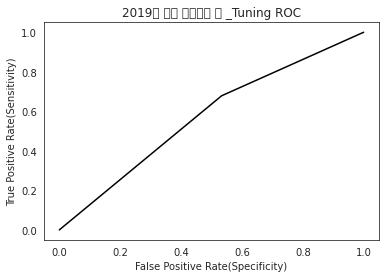

In [119]:
# Model Evaluation (AUC)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
roc_auc = metrics.auc(fpr, tpr)
print("2019년 여성 직장인구 수_Tuning AUC =", roc_auc)

# ROC
plt.title('2019년 여성 직장인구 수 _Tuning ROC')
plt.xlabel('False Positive Rate(Specificity)')
plt.ylabel('True Positive Rate(Sensitivity)')
plt.plot(fpr, tpr, 'k', label=roc_auc); 


### 12.1 남성 직장 인구수 

In [120]:
# 남성직장인구 수 (2017년)

X = df_x.values
y = df_y_17.남성_직장_인구_수_1년.values

# Train, Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

In [121]:
#객체생성 
xgb = XGBClassifier(random_state=18)

# 하이퍼파라미터 튜닝
params = {
    'learning_rate': list(np.concatenate([np.arange(1,11)/100, np.arange(2,11)/10, np.arange(2,11)])), 'n_estimators': list(range(100, 400,  100)),
    'n_iter': list(range(100, 1000, 100)),
    'max_depth': list(range(4, 20)),
    }
           
# XGBClassifier 객체 생성 후 GridSearchCV 수행
grid_xgb = GridSearchCV(xgb, param_grid = params, n_jobs = -1, verbose=1, scoring='roc_auc')
grid_xgb.fit(X_train, y_train)

print('최적 하이퍼 파라미터: ', grid_xgb.best_params_)
print('최고 예측 정확도: {:.4f}'.format(grid_xgb.best_score_))

Fitting 5 folds for each of 12096 candidates, totalling 60480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 648 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 2048 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 3848 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 6048 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 8648 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done 11648 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done 15048 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 18848 tasks      | elapsed:   19.4s
[Parallel(n_jobs=-1)]: Done 23048 tasks      | elapsed:   23.0s
[Parallel(n_jobs=-1)]: Done 27648 tasks      | elapsed:   26.6s
[Parallel(n_jobs=-1)]: Done 32648 tasks      | elapsed:   30.3s
[Parallel(n_jobs=-1)]: Done 38048 tasks      | elapsed:   33.9s
[Parallel(n_jobs=-1)]: Done 43848 tasks      | elapsed:   37.4s
[Parallel(n_jobs=-1)]: Done 55424 t

[14:02:12] WARNING: ../src/learner.cc:516: 
Parameters: { n_iter } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


최적 하이퍼 파라미터:  {'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 100, 'n_iter': 100}
최고 예측 정확도: 0.6579


[Parallel(n_jobs=-1)]: Done 60480 out of 60480 | elapsed:   44.3s finished


In [122]:
xgb1= XGBClassifier(n_estimators = 100, 
                    max_depth = 6,
                    n_iter = 100,
                    learning_rate = 0.01,
                    random_state = 18,
                    n_jobs = -1
                    )
xgb1.fit(X_train, y_train)
y_pred = xgb1.predict(X_test)
print('예측 정확도: {:.4f}'.format(accuracy_score(y_test,y_pred)))

[14:02:27] WARNING: ../src/learner.cc:516: 
Parameters: { n_iter } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


예측 정확도: 0.5743


2017년_남성직장인구 수 _Tuning AUC = 0.5361178369652946


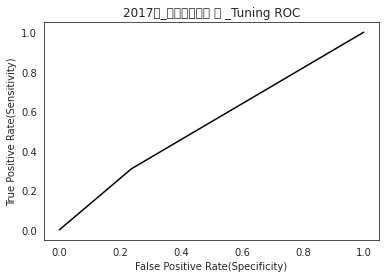

In [123]:
# Model Evaluation (AUC)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
roc_auc = metrics.auc(fpr, tpr)
print("2017년_남성직장인구 수 _Tuning AUC =", roc_auc)

# ROC
plt.title('2017년_남성직장인구 수 _Tuning ROC')
plt.xlabel('False Positive Rate(Specificity)')
plt.ylabel('True Positive Rate(Sensitivity)')
plt.plot(fpr, tpr, 'k', label=roc_auc); 

### 12.2 남성직장인구 (3년)

In [124]:
# 남성직장인구 수  (2019년)

X = df_x.values
y = df_y_19.남성_직장_인구_수_3년.values

# Train, Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

In [125]:
#객체생성 
xgb = XGBClassifier(random_state=18)

# 하이퍼파라미터 튜닝
params = {
    'learning_rate': list(np.concatenate([np.arange(1,11)/100, np.arange(2,11)/10, np.arange(2,11)])), 'n_estimators': list(range(100, 400,  100)),
    'n_iter': list(range(100, 1000, 100)),
    'max_depth': list(range(4, 20)),
    }
           
# XGBClassifier 객체 생성 후 GridSearchCV 수행
grid_xgb = GridSearchCV(xgb, param_grid = params, n_jobs = -1, verbose=1, scoring='roc_auc')
grid_xgb.fit(X_train, y_train)

print('최적 하이퍼 파라미터: ', grid_xgb.best_params_)
print('최고 예측 정확도: {:.4f}'.format(grid_xgb.best_score_))

Fitting 5 folds for each of 12096 candidates, totalling 60480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 648 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 2048 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 3848 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 6048 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 8648 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done 11648 tasks      | elapsed:   12.0s
[Parallel(n_jobs=-1)]: Done 15048 tasks      | elapsed:   15.4s
[Parallel(n_jobs=-1)]: Done 18848 tasks      | elapsed:   18.9s
[Parallel(n_jobs=-1)]: Done 23048 tasks      | elapsed:   22.6s
[Parallel(n_jobs=-1)]: Done 27648 tasks      | elapsed:   26.2s
[Parallel(n_jobs=-1)]: Done 32648 tasks      | elapsed:   29.8s
[Parallel(n_jobs=-1)]: Done 38048 tasks      | elapsed:   33.5s
[Parallel(n_jobs=-1)]: Done 43848 tasks      | elapsed:   37.0s
[Parallel(n_jobs=-1)]: Done 60085 t

[14:03:24] WARNING: ../src/learner.cc:516: 
Parameters: { n_iter } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


최적 하이퍼 파라미터:  {'learning_rate': 5.0, 'max_depth': 10, 'n_estimators': 200, 'n_iter': 100}
최고 예측 정확도: 0.5885


In [130]:
xgb1= XGBClassifier(n_estimators = 200, 
                    max_depth = 10,
                    n_iter = 100,
                    learning_rate = 5.0,
                    random_state = 18,
                    n_jobs = -1,
                    scoring='roc_auc')
xgb1.fit(X_train, y_train)
y_pred = xgb1.predict(X_test)
print('예측 정확도: {:.4f}'.format(accuracy_score(y_test,y_pred)))

[14:03:48] WARNING: ../src/learner.cc:516: 
Parameters: { n_iter, scoring } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


예측 정확도: 0.6238


2019년_남성직장인구 수_Tuning AUC = 0.4975538160469667


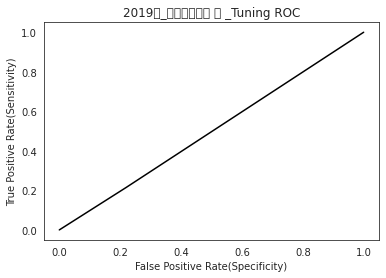

In [131]:
# Model Evaluation (AUC)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
roc_auc = metrics.auc(fpr, tpr)
print("2019년_남성직장인구 수_Tuning AUC =", roc_auc)

# ROC
plt.title('2019년_남성직장인구 수 _Tuning ROC')
plt.xlabel('False Positive Rate(Specificity)')
plt.ylabel('True Positive Rate(Sensitivity)')
plt.plot(fpr, tpr, 'k', label=roc_auc); 

### 13.1 10대 직장 인구 수  (1년)

In [132]:
# 10대 직장 인구 수  (2017년)

X = df_x.values
y = df_y_17.연령대_10_직장_인구_수_1년.values

# Train, Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

In [133]:
np.concatenate([np.arange(1,11)/100, np.arange(2,11)/10, np.arange(2,11)])

array([ 0.01,  0.02,  0.03,  0.04,  0.05,  0.06,  0.07,  0.08,  0.09,
        0.1 ,  0.2 ,  0.3 ,  0.4 ,  0.5 ,  0.6 ,  0.7 ,  0.8 ,  0.9 ,
        1.  ,  2.  ,  3.  ,  4.  ,  5.  ,  6.  ,  7.  ,  8.  ,  9.  ,
       10.  ])

In [134]:
#객체생성 
xgb = XGBClassifier(random_state=18)

# 하이퍼파라미터 튜닝
params = {
    'learning_rate': list(np.concatenate([np.arange(1,11)/100, np.arange(2,11)/10, np.arange(2,11)])), 'n_estimators': list(range(100, 400,  100)),
    'n_iter': list(range(100, 1000, 100)),
    'max_depth': list(range(4, 20)),
    }
           
# XGBClassifier 객체 생성 후 GridSearchCV 수행
grid_xgb = GridSearchCV(xgb, param_grid = params, n_jobs = -1, verbose=1, scoring='roc_auc')
grid_xgb.fit(X_train, y_train)

print('최적 하이퍼 파라미터: ', grid_xgb.best_params_)
print('최고 예측 정확도: {:.4f}'.format(grid_xgb.best_score_))

Fitting 5 folds for each of 12096 candidates, totalling 60480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 648 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 3200 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 6800 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 11200 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done 16400 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done 22400 tasks      | elapsed:   20.8s
[Parallel(n_jobs=-1)]: Done 29200 tasks      | elapsed:   25.7s
[Parallel(n_jobs=-1)]: Done 36800 tasks      | elapsed:   30.5s
[Parallel(n_jobs=-1)]: Done 45200 tasks      | elapsed:   35.0s
[Parallel(n_jobs=-1)]: Done 54400 tasks      | elapsed:   39.2s
[Parallel(n_jobs=-1)]: Done 60353 out of 60480 | elapsed:   41.4s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 60480 out of 60480 | elapsed:   41.4s finished


[14:04:44] WARNING: ../src/learner.cc:516: 
Parameters: { n_iter } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


최적 하이퍼 파라미터:  {'learning_rate': 2.0, 'max_depth': 6, 'n_estimators': 300, 'n_iter': 100}
최고 예측 정확도: 0.6921


In [135]:
xgb1= XGBClassifier(n_estimators = 300, 
                    max_depth = 6,
                    n_iter = 100,
                    learning_rate = 2.0,
                    random_state = 18,
                    n_jobs = -1
                    )
xgb1.fit(X_train, y_train)
y_pred = xgb1.predict(X_test)
print('예측 정확도: {:.4f}'.format(accuracy_score(y_test,y_pred)))

[14:05:01] WARNING: ../src/learner.cc:516: 
Parameters: { n_iter } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


예측 정확도: 0.5644


2017년_10대 직장 인구 수 _Tuning AUC = 0.4784735812133072


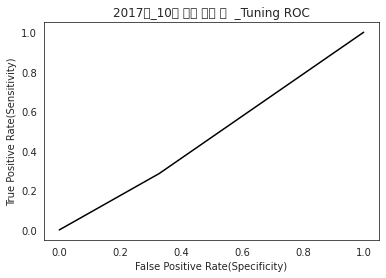

In [136]:
# Model Evaluation (AUC)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
roc_auc = metrics.auc(fpr, tpr)
print("2017년_10대 직장 인구 수 _Tuning AUC =", roc_auc)

# ROC
plt.title('2017년_10대 직장 인구 수  _Tuning ROC')
plt.xlabel('False Positive Rate(Specificity)')
plt.ylabel('True Positive Rate(Sensitivity)')
plt.plot(fpr, tpr, 'k', label=roc_auc); 

### 13.2 10대 직장 인구 수 (3년)

In [137]:
# 10대 직장 인구 수  (2019년)

X = df_x.values
y = df_y_19.연령대_10_직장_인구_수_3년.values

# Train, Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

In [138]:
#객체생성 
xgb = XGBClassifier(random_state=18)

# 하이퍼파라미터 튜닝
params = {
    'learning_rate': list(np.concatenate([np.arange(1,11)/100, np.arange(2,11)/10, np.arange(2,11)])), 'n_estimators': list(range(100, 400,  100)),
    'n_iter': list(range(100, 1000, 100)),
    'max_depth': list(range(4, 20)),
    }
           
# XGBClassifier 객체 생성 후 GridSearchCV 수행
grid_xgb = GridSearchCV(xgb, param_grid = params, n_jobs = -1, verbose=1, scoring='roc_auc')
grid_xgb.fit(X_train, y_train)

print('최적 하이퍼 파라미터: ', grid_xgb.best_params_)
print('최고 예측 정확도: {:.4f}'.format(grid_xgb.best_score_))

Fitting 5 folds for each of 12096 candidates, totalling 60480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 648 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 3200 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 6800 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 11200 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done 16400 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done 22400 tasks      | elapsed:   21.2s
[Parallel(n_jobs=-1)]: Done 29200 tasks      | elapsed:   26.2s
[Parallel(n_jobs=-1)]: Done 36800 tasks      | elapsed:   31.1s
[Parallel(n_jobs=-1)]: Done 45200 tasks      | elapsed:   35.7s
[Parallel(n_jobs=-1)]: Done 54400 tasks      | elapsed:   40.2s


[14:06:19] WARNING: ../src/learner.cc:516: 
Parameters: { n_iter } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


최적 하이퍼 파라미터:  {'learning_rate': 0.9, 'max_depth': 6, 'n_estimators': 300, 'n_iter': 100}
최고 예측 정확도: 0.5988


[Parallel(n_jobs=-1)]: Done 60480 out of 60480 | elapsed:   42.4s finished


In [139]:
xgb1= XGBClassifier(n_estimators = 300 , 
                    max_depth = 6,
                    n_iter = 100,
                    learning_rate = 0.9,
                    random_state = 18,
                    n_jobs = -1
                    )
xgb1.fit(X_train, y_train)
y_pred = xgb1.predict(X_test)
print('예측 정확도: {:.4f}'.format(accuracy_score(y_test,y_pred)))

[14:06:32] WARNING: ../src/learner.cc:516: 
Parameters: { n_iter } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


예측 정확도: 0.6139


2017년_10대 직장 인구 수_Tuning AUC = 0.5104723707664884


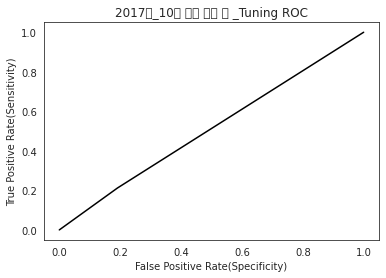

In [140]:
# Model Evaluation (AUC)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
roc_auc = metrics.auc(fpr, tpr)
print("2017년_10대 직장 인구 수_Tuning AUC =", roc_auc)

# ROC
plt.title('2017년_10대 직장 인구 수 _Tuning ROC')
plt.xlabel('False Positive Rate(Specificity)')
plt.ylabel('True Positive Rate(Sensitivity)')
plt.plot(fpr, tpr, 'k', label=roc_auc); 

### 14.1 30대 직장 인구 수 (1년)

In [141]:
# 30대 직장 인구 수  (2017년)

X = df_x.values
y = df_y_17.연령대_30_직장_인구_수_1년.values

# Train, Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

In [142]:
#객체생성 
xgb = XGBClassifier(random_state=18)

# 하이퍼파라미터 튜닝
params = {
    'learning_rate': list(np.concatenate([np.arange(1,11)/100, np.arange(2,11)/10, np.arange(2,11)])), 'n_estimators': list(range(100, 400,  100)),
    'n_iter': list(range(100, 1000, 100)),
    'max_depth': list(range(4, 20)),
    }
           
# XGBClassifier 객체 생성 후 GridSearchCV 수행
grid_xgb = GridSearchCV(xgb, param_grid = params, n_jobs = -1, verbose=1, scoring='roc_auc')
grid_xgb.fit(X_train, y_train)

print('최적 하이퍼 파라미터: ', grid_xgb.best_params_)
print('최고 예측 정확도: {:.4f}'.format(grid_xgb.best_score_))

Fitting 5 folds for each of 12096 candidates, totalling 60480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 648 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 3200 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 6800 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 11200 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done 16400 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 22400 tasks      | elapsed:   20.8s
[Parallel(n_jobs=-1)]: Done 29200 tasks      | elapsed:   25.9s
[Parallel(n_jobs=-1)]: Done 36800 tasks      | elapsed:   30.9s
[Parallel(n_jobs=-1)]: Done 45200 tasks      | elapsed:   35.4s
[Parallel(n_jobs=-1)]: Done 54400 tasks      | elapsed:   39.4s


[14:07:28] WARNING: ../src/learner.cc:516: 
Parameters: { n_iter } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


최적 하이퍼 파라미터:  {'learning_rate': 4.0, 'max_depth': 4, 'n_estimators': 100, 'n_iter': 100}
최고 예측 정확도: 0.5914


[Parallel(n_jobs=-1)]: Done 60480 out of 60480 | elapsed:   41.6s finished


In [144]:
xgb1= XGBClassifier(n_estimators = 100 , 
                    max_depth = 4,
                    n_iter = 100,
                    learning_rate = 0.01,
                    random_state = 18,
                    n_jobs = -1
                    )
xgb1.fit(X_train, y_train)
y_pred = xgb1.predict(X_test)
print('예측 정확도: {:.4f}'.format(accuracy_score(y_test,y_pred)))

[14:08:37] WARNING: ../src/learner.cc:516: 
Parameters: { n_iter } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


예측 정확도: 0.7129


2017년_30대_직장인구 수_Tuning AUC = 0.5720108695652174


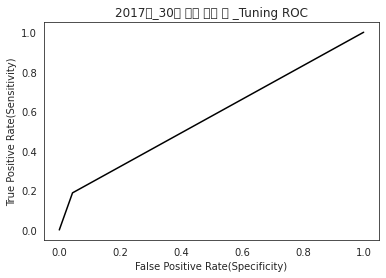

In [145]:
# Model Evaluation (AUC)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
roc_auc = metrics.auc(fpr, tpr)
print("2017년_30대_직장인구 수_Tuning AUC =", roc_auc)

# ROC
plt.title('2017년_30대 직장 인구 수 _Tuning ROC')
plt.xlabel('False Positive Rate(Specificity)')
plt.ylabel('True Positive Rate(Sensitivity)')
plt.plot(fpr, tpr, 'k', label=roc_auc); 

### 14.2 30대 직장 인구 수 (3년)

In [146]:
# 30대 직장 인구 수  (2019년)

X = df_x.values
y = df_y_19.연령대_30_직장_인구_수_3년.values

# Train, Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

In [147]:
#객체생성 
xgb = XGBClassifier(random_state=18)

# 하이퍼파라미터 튜닝
params = {
    'learning_rate': list(np.concatenate([np.arange(1,11)/100, np.arange(2,11)/10, np.arange(2,11)])), 'n_estimators': list(range(100, 400,  100)),
    'n_iter': list(range(100, 1000, 100)),
    'max_depth': list(range(4, 20)),
    }
           
# XGBClassifier 객체 생성 후 GridSearchCV 수행
grid_xgb = GridSearchCV(xgb, param_grid = params, n_jobs = -1, verbose=1, scoring='roc_auc')
grid_xgb.fit(X_train, y_train)

print('최적 하이퍼 파라미터: ', grid_xgb.best_params_)
print('최고 예측 정확도: {:.4f}'.format(grid_xgb.best_score_))

Fitting 5 folds for each of 12096 candidates, totalling 60480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 648 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 3200 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 6800 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 11200 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done 16400 tasks      | elapsed:   16.5s
[Parallel(n_jobs=-1)]: Done 22400 tasks      | elapsed:   21.7s
[Parallel(n_jobs=-1)]: Done 29200 tasks      | elapsed:   26.9s
[Parallel(n_jobs=-1)]: Done 36800 tasks      | elapsed:   32.1s
[Parallel(n_jobs=-1)]: Done 45200 tasks      | elapsed:   36.8s
[Parallel(n_jobs=-1)]: Done 54400 tasks      | elapsed:   40.9s


[14:09:31] WARNING: ../src/learner.cc:516: 
Parameters: { n_iter } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


최적 하이퍼 파라미터:  {'learning_rate': 3.0, 'max_depth': 5, 'n_estimators': 300, 'n_iter': 100}
최고 예측 정확도: 0.5909


[Parallel(n_jobs=-1)]: Done 60480 out of 60480 | elapsed:   43.2s finished


In [148]:
xgb1= XGBClassifier(n_estimators =300 , 
                    max_depth =5 ,
                    n_iter = 100,
                    learning_rate = 3.0,
                    random_state = 18,
                    n_jobs = -1
                    )
xgb1.fit(X_train, y_train)
y_pred = xgb1.predict(X_test)
print('예측 정확도: {:.4f}'.format(accuracy_score(y_test,y_pred)))

[14:09:58] WARNING: ../src/learner.cc:516: 
Parameters: { n_iter } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


예측 정확도: 0.5446


2019년_30대_직장인구 수_Tuning AUC = 0.5


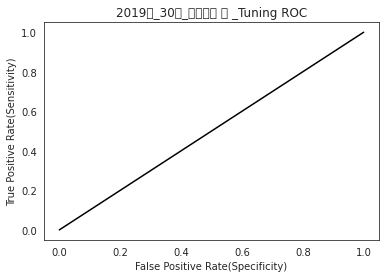

In [149]:
# Model Evaluation (AUC)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
roc_auc = metrics.auc(fpr, tpr)
print("2019년_30대_직장인구 수_Tuning AUC =", roc_auc)

# ROC
plt.title('2019년_30대_직장인구 수 _Tuning ROC')
plt.xlabel('False Positive Rate(Specificity)')
plt.ylabel('True Positive Rate(Sensitivity)')
plt.plot(fpr, tpr, 'k', label=roc_auc); 

### 15.1 거주 세대 수 (1년)

In [150]:
# 거주 세대 수  (2017년)

X = df_x.values
y = df_y_17.거주_세대_수_1년.values

# Train, Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

In [151]:
#객체생성 
xgb = XGBClassifier(random_state=18)

# 하이퍼파라미터 튜닝
params = {
    'learning_rate': list(np.concatenate([np.arange(1,11)/100, np.arange(2,11)/10, np.arange(2,11)])), 'n_estimators': list(range(100, 400,  100)),
    'n_iter': list(range(100, 1000, 100)),
    'max_depth': list(range(4, 20)),
    }
           
# XGBClassifier 객체 생성 후 GridSearchCV 수행
grid_xgb = GridSearchCV(xgb, param_grid = params, n_jobs = -1, verbose=1, scoring='roc_auc')
grid_xgb.fit(X_train, y_train)

print('최적 하이퍼 파라미터: ', grid_xgb.best_params_)
print('최고 예측 정확도: {:.4f}'.format(grid_xgb.best_score_))

Fitting 5 folds for each of 12096 candidates, totalling 60480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 648 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 3200 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 6800 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 11200 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done 16400 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done 22400 tasks      | elapsed:   21.3s
[Parallel(n_jobs=-1)]: Done 29200 tasks      | elapsed:   26.2s
[Parallel(n_jobs=-1)]: Done 36800 tasks      | elapsed:   31.0s
[Parallel(n_jobs=-1)]: Done 45200 tasks      | elapsed:   35.4s
[Parallel(n_jobs=-1)]: Done 54400 tasks      | elapsed:   39.5s


[14:10:57] WARNING: ../src/learner.cc:516: 
Parameters: { n_iter } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


최적 하이퍼 파라미터:  {'learning_rate': 2.0, 'max_depth': 5, 'n_estimators': 300, 'n_iter': 100}
최고 예측 정확도: 0.6150


[Parallel(n_jobs=-1)]: Done 60353 out of 60480 | elapsed:   41.6s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 60480 out of 60480 | elapsed:   41.7s finished


In [152]:
xgb1= XGBClassifier(n_estimators = 300, 
                    max_depth = 5,
                    n_iter = 100,
                    learning_rate = 2.0,
                    random_state = 18,
                    n_jobs = -1
                    )
xgb1.fit(X_train, y_train)
y_pred = xgb1.predict(X_test)
print('예측 정확도: {:.4f}'.format(accuracy_score(y_test,y_pred)))

[14:11:13] WARNING: ../src/learner.cc:516: 
Parameters: { n_iter } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


예측 정확도: 0.5743


2017년_거주세대 수 _Tuning AUC = 0.541260162601626


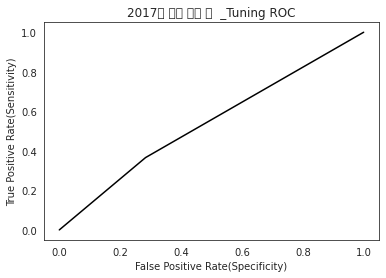

In [153]:
# Model Evaluation (AUC)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
roc_auc = metrics.auc(fpr, tpr)
print("2017년_거주세대 수 _Tuning AUC =", roc_auc)

# ROC
plt.title('2017년 거주 세대 수  _Tuning ROC')
plt.xlabel('False Positive Rate(Specificity)')
plt.ylabel('True Positive Rate(Sensitivity)')
plt.plot(fpr, tpr, 'k', label=roc_auc); 

### 15.2 거주 세대 수 (3년)

In [154]:
# 거주 세대 수  (2019년)

X = df_x.values
y = df_y_19.거주_세대_수_3년.values

# Train, Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

In [155]:
# 하이퍼파라미터 튜닝
from sklearn.model_selection import GridSearchCV

params = {'n_estimators' :[300,400,500],
           'max_depth' : list(range(4, 20)),
           'criterion' : ['gini', 'entropy']
           }

# RandomForestClassifier 객체 생성 후 GridSearchCV 수행
rf_clf = RandomForestClassifier(random_state = 0, n_jobs = -1)
grid_cv = GridSearchCV(rf_clf, param_grid = params, scoring='roc_auc', cv = 5, n_jobs = -1)
grid_cv.fit(X_train, y_train)

print('최적 하이퍼 파라미터: ', grid_cv.best_params_)

최적 하이퍼 파라미터:  {'criterion': 'gini', 'max_depth': 16, 'n_estimators': 500}


In [151]:
# 다시 학습 및 예측 성능 측정
rf_clf1 = RandomForestClassifier(n_estimators = 500, 
                                max_depth = 14,
                                random_state = 1 ,
                                criterion = 'entropy')
rf_clf1.fit(X_train, y_train)
y_pred = rf_clf1.predict(X_test)
print('예측 정확도: {:.4f}'.format(accuracy_score(y_test,y_pred)))

예측 정확도: 0.5842


2019년_거주 세대 수 _Tuning AUC = 0.5801886792452831


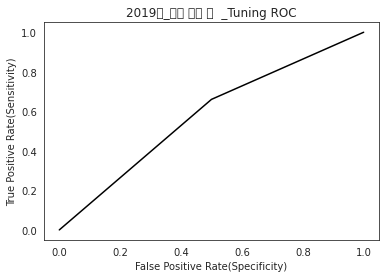

In [152]:
# Model Evaluation (AUC)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
roc_auc = metrics.auc(fpr, tpr)
print("2019년_거주 세대 수 _Tuning AUC =", roc_auc)

# ROC
plt.title('2019년_거주 세대 수  _Tuning ROC')
plt.xlabel('False Positive Rate(Specificity)')
plt.ylabel('True Positive Rate(Sensitivity)')
plt.plot(fpr, tpr, 'k', label=roc_auc); 

### 16.1 지출 총 금액 (1년)

In [6]:
# 지출 총금액   (2017년)
X = df_x.values
y = df_y_17.지출_총금액_1년.values

# Train, Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

In [178]:
log_reg = LogisticRegression()

# 하이퍼파라미터 튜닝
params = {'C':list(np.concatenate([np.arange(0.01,1,0.01), np.arange(1,10,1)]))}
           
# Logistic Regression 객체 생성 후 GridSearchCV 수행
grid_log = GridSearchCV(log_reg, params, cv=5)
grid_log.fit(X_train, y_train)

print('최적 하이퍼 파라미터: ', grid_log.best_params_)
print('최고 예측 정확도: {:.4f}'.format(grid_log.best_score_))

최적 하이퍼 파라미터:  {'C': 2.0}
최고 예측 정확도: 0.6240


In [179]:
# 다시 학습 및 예측 성능 측정
lg_clf = LogisticRegression(C= 2.0,
                                n_jobs=-1,
                                random_state=18,
                                verbose=0)
lg_clf.fit(X_train, y_train)
y_pred = lg_clf.predict(X_test)
print('예측 정확도: {:.4f}'.format(accuracy_score(y_test,y_pred)))

예측 정확도: 0.5941


2017년 지출 총금액_Tuning AUC = 0.5124069478908189


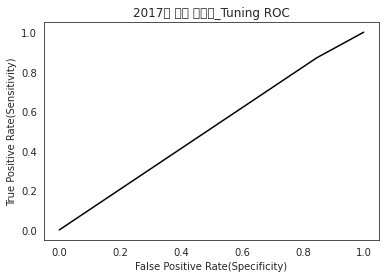

In [180]:
# Model Evaluation (AUC)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
roc_auc = metrics.auc(fpr, tpr)
print("2017년 지출 총금액_Tuning AUC =", roc_auc)

# ROC
plt.title('2017년 지출 총금액_Tuning ROC')
plt.xlabel('False Positive Rate(Specificity)')
plt.ylabel('True Positive Rate(Sensitivity)')
plt.plot(fpr, tpr, 'k', label=roc_auc); 

### 16.2 지출 총 금액  (3년)

In [157]:
# 지출_총금액_3년  (2019년)
X = df_x.values
y = df_y_19.지출_총금액_3년.values

# Train, Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

In [158]:
# 하이퍼파라미터 튜닝
from sklearn.model_selection import GridSearchCV

params = {'n_estimators' :[300,400,500],
           'max_depth' : list(range(4, 20)),
           'criterion' : ['gini', 'entropy']
           }

# RandomForestClassifier 객체 생성 후 GridSearchCV 수행
rf_clf = RandomForestClassifier(random_state = 0, n_jobs = -1)
grid_cv = GridSearchCV(rf_clf, param_grid = params, cv = 5, scoring='roc_auc', n_jobs = -1)
grid_cv.fit(X_train, y_train)

print('최적 하이퍼 파라미터: ', grid_cv.best_params_)

최적 하이퍼 파라미터:  {'criterion': 'entropy', 'max_depth': 14, 'n_estimators': 300}


In [159]:
# 다시 학습 및 예측 성능 측정
rf_clf1 = RandomForestClassifier(n_estimators = 300, 
                                max_depth = 14,
                                random_state = 1,
                                criterion = 'entropy')
rf_clf1.fit(X_train, y_train)
y_pred = rf_clf1.predict(X_test)
print('예측 정확도: {:.4f}'.format(accuracy_score(y_test,y_pred)))

예측 정확도: 0.6436


2019년 지출 총금액_Tuning AUC = 0.5325311942959002


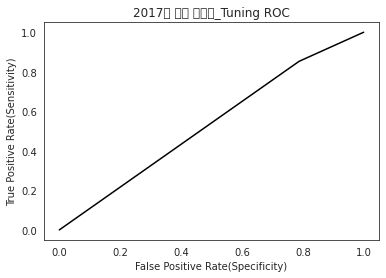

In [160]:
# Model Evaluation (AUC)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
roc_auc = metrics.auc(fpr, tpr)
print("2019년 지출 총금액_Tuning AUC =", roc_auc)

# ROC
plt.title('2017년 지출 총금액_Tuning ROC')
plt.xlabel('False Positive Rate(Specificity)')
plt.ylabel('True Positive Rate(Sensitivity)')
plt.plot(fpr, tpr, 'k', label=roc_auc); 

### 17.1 의류, 신발  지출 총금액 (1년)

In [161]:
# 의류, 신발 지출 총금액  (2017년)
X = df_x.values
y = df_y_17.의류_신발_지출_총금액_1년.values

# Train, Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

In [162]:
# 하이퍼파라미터 튜닝
from sklearn.model_selection import GridSearchCV

params = {'n_estimators' :[300,400,500],
           'max_depth' : list(range(4, 20)),
           'criterion' : ['gini', 'entropy']
           }

# RandomForestClassifier 객체 생성 후 GridSearchCV 수행
rf_clf = RandomForestClassifier(random_state = 0, n_jobs = -1)
grid_cv = GridSearchCV(rf_clf, param_grid = params, scoring='roc_auc', cv = 5, n_jobs = -1)
grid_cv.fit(X_train, y_train)

print('최적 하이퍼 파라미터: ', grid_cv.best_params_)

최적 하이퍼 파라미터:  {'criterion': 'gini', 'max_depth': 17, 'n_estimators': 400}


In [163]:
# 다시 학습 및 예측 성능 측정
rf_clf1 = RandomForestClassifier(n_estimators = 400, 
                                max_depth = 17,
                                random_state = 1,
                                criterion = 'gini')
rf_clf1.fit(X_train, y_train)
y_pred = rf_clf1.predict(X_test)
print('예측 정확도: {:.4f}'.format(accuracy_score(y_test,y_pred)))

예측 정확도: 0.5743


2017년 의류_신발_지출_총금액_Tuning AUC = 0.5057899090157154


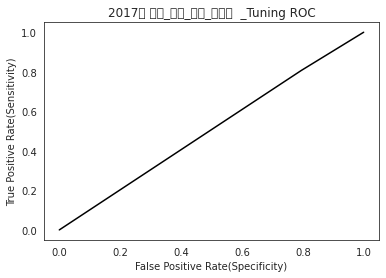

In [164]:
# Model Evaluation (AUC)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
roc_auc = metrics.auc(fpr, tpr)
print("2017년 의류_신발_지출_총금액_Tuning AUC =", roc_auc)

# ROC
plt.title('2017년 의류_신발_지출_총금액  _Tuning ROC')
plt.xlabel('False Positive Rate(Specificity)')
plt.ylabel('True Positive Rate(Sensitivity)')
plt.plot(fpr, tpr, 'k', label=roc_auc); 


### 17.2 의류 , 신발 지출 총금 액 (3년)

In [165]:
# 의류, 신발 지출 총금액   (2019년)
X = df_x.values
y = df_y_19.의류_신발_지출_총금액_3년.values

# Train, Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

In [166]:
#객체생성 
xgb = XGBClassifier(random_state=18)

# 하이퍼파라미터 튜닝
params = {
    'learning_rate': list(np.concatenate([np.arange(1,11)/100, np.arange(2,11)/10, np.arange(2,11)])), 'n_estimators': list(range(100, 400,  100)),
    'n_iter': list(range(100, 1000, 100)),
    'max_depth': list(range(4, 20)),
    }
           
# XGBClassifier 객체 생성 후 GridSearchCV 수행
grid_xgb = GridSearchCV(xgb, param_grid = params, n_jobs = -1, verbose=1, scoring='roc_auc')
grid_xgb.fit(X_train, y_train)

print('최적 하이퍼 파라미터: ', grid_xgb.best_params_)
print('최고 예측 정확도: {:.4f}'.format(grid_xgb.best_score_))

Fitting 5 folds for each of 12096 candidates, totalling 60480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 648 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 2048 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 3848 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 6048 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 8648 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done 11648 tasks      | elapsed:   12.0s
[Parallel(n_jobs=-1)]: Done 15048 tasks      | elapsed:   15.3s
[Parallel(n_jobs=-1)]: Done 18848 tasks      | elapsed:   18.8s
[Parallel(n_jobs=-1)]: Done 23048 tasks      | elapsed:   22.3s
[Parallel(n_jobs=-1)]: Done 27648 tasks      | elapsed:   25.8s
[Parallel(n_jobs=-1)]: Done 32648 tasks      | elapsed:   29.3s
[Parallel(n_jobs=-1)]: Done 38048 tasks      | elapsed:   32.8s
[Parallel(n_jobs=-1)]: Done 43848 tasks      | elapsed:   36.5s
[Parallel(n_jobs=-1)]: Done 56192 t

[14:17:13] WARNING: ../src/learner.cc:516: 
Parameters: { n_iter } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


최적 하이퍼 파라미터:  {'learning_rate': 0.9, 'max_depth': 8, 'n_estimators': 300, 'n_iter': 100}
최고 예측 정확도: 0.6702


[Parallel(n_jobs=-1)]: Done 60480 out of 60480 | elapsed:   43.2s finished


In [167]:
xgb1= XGBClassifier(n_estimators = 300, 
                    max_depth = 8,
                    n_iter = 100,
                    learning_rate = 0.9,
                    random_state = 18,
                    n_jobs = -1
                    )
xgb1.fit(X_train, y_train)
y_pred = xgb1.predict(X_test)
print('예측 정확도: {:.4f}'.format(accuracy_score(y_test,y_pred)))

[14:17:35] WARNING: ../src/learner.cc:516: 
Parameters: { n_iter } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


예측 정확도: 0.6337


2019년 의류,신발 지출 총금액_Tuning AUC = 0.5790166812993854


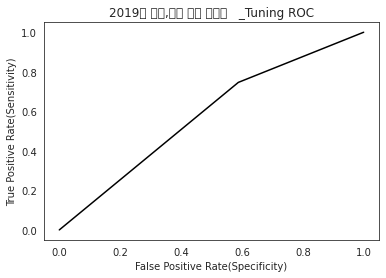

In [168]:
# Model Evaluation (AUC)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
roc_auc = metrics.auc(fpr, tpr)
print("2019년 의류,신발 지출 총금액_Tuning AUC =", roc_auc)

# ROC
plt.title('2019년 의류,신발 지출 총금액   _Tuning ROC')
plt.xlabel('False Positive Rate(Specificity)')
plt.ylabel('True Positive Rate(Sensitivity)')
plt.plot(fpr, tpr, 'k', label=roc_auc); 


### 18.1 의료비 지출 (1년)

In [181]:
# 의료비_지출_총금액_1년  (2017년)

X = df_x.values
y = df_y_17.의료비_지출_총금액_1년.values

# Train, Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

In [170]:
#객체생성 
xgb = XGBClassifier(random_state=18)

# 하이퍼파라미터 튜닝
params = {
    'learning_rate': list(np.concatenate([np.arange(1,11)/100, np.arange(2,11)/10, np.arange(2,11)])), 'n_estimators': list(range(100, 400,  100)),
    'n_iter': list(range(100, 1000, 100)),
    'max_depth': list(range(4, 20)),
    }
           
# XGBClassifier 객체 생성 후 GridSearchCV 수행
grid_xgb = GridSearchCV(xgb, param_grid = params, n_jobs = -1, verbose=1, scoring='roc_auc')
grid_xgb.fit(X_train, y_train)

print('최적 하이퍼 파라미터: ', grid_xgb.best_params_)
print('최고 예측 정확도: {:.4f}'.format(grid_xgb.best_score_))

Fitting 5 folds for each of 12096 candidates, totalling 60480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 648 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 3200 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 6800 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 11200 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done 16400 tasks      | elapsed:   16.8s
[Parallel(n_jobs=-1)]: Done 22400 tasks      | elapsed:   21.8s
[Parallel(n_jobs=-1)]: Done 29200 tasks      | elapsed:   26.9s
[Parallel(n_jobs=-1)]: Done 36800 tasks      | elapsed:   31.7s
[Parallel(n_jobs=-1)]: Done 45200 tasks      | elapsed:   36.3s
[Parallel(n_jobs=-1)]: Done 54400 tasks      | elapsed:   40.5s


[14:18:31] WARNING: ../src/learner.cc:516: 
Parameters: { n_iter } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


최적 하이퍼 파라미터:  {'learning_rate': 1.0, 'max_depth': 8, 'n_estimators': 100, 'n_iter': 100}
최고 예측 정확도: 0.6413


[Parallel(n_jobs=-1)]: Done 60480 out of 60480 | elapsed:   42.6s finished


In [182]:
xgb1= XGBClassifier(n_estimators = 100, 
                    max_depth = 8,
                    n_iter = 100,
                    learning_rate = 1.0,
                    random_state = 18,
                    n_jobs = -1
                    )
xgb1.fit(X_train, y_train)
y_pred = xgb1.predict(X_test)
print('예측 정확도: {:.4f}'.format(accuracy_score(y_test,y_pred)))

[14:21:36] WARNING: ../src/learner.cc:516: 
Parameters: { n_iter } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


예측 정확도: 0.5941


2017년_의료비 지출 총금액Tuning AUC = 0.5599273607748183


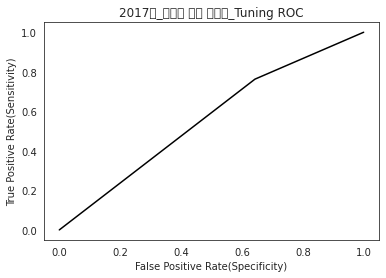

In [183]:
# Model Evaluation (AUC)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
roc_auc = metrics.auc(fpr, tpr)
print("2017년_의료비 지출 총금액Tuning AUC =", roc_auc)

# ROC
plt.title('2017년_의료비 지출 충금액_Tuning ROC')
plt.xlabel('False Positive Rate(Specificity)')
plt.ylabel('True Positive Rate(Sensitivity)')
plt.plot(fpr, tpr, 'k', label=roc_auc); 

### 18.2 의료비 지출 (3년)

In [184]:
# 의료비_지출_총금액_3년 (2019년)

X = df_x.values
y = df_y_19.의료비_지출_총금액_3년.values

# Train, Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

In [185]:
#객체생성 
xgb = XGBClassifier(random_state=18)

# 하이퍼파라미터 튜닝
params = {
    'learning_rate': list(np.concatenate([np.arange(1,11)/100, np.arange(2,11)/10, np.arange(2,11)])), 'n_estimators': list(range(100, 400,  100)),
    'n_iter': list(range(100, 1000, 100)),
    'max_depth': list(range(4, 20)),
    }
           
# XGBClassifier 객체 생성 후 GridSearchCV 수행
grid_xgb = GridSearchCV(xgb, param_grid = params, n_jobs = -1, verbose=1, scoring='roc_auc')
grid_xgb.fit(X_train, y_train)

print('최적 하이퍼 파라미터: ', grid_xgb.best_params_)
print('최고 예측 정확도: {:.4f}'.format(grid_xgb.best_score_))

Fitting 5 folds for each of 12096 candidates, totalling 60480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 648 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 2048 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 3848 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 6048 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 8648 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done 11648 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done 15048 tasks      | elapsed:   15.2s
[Parallel(n_jobs=-1)]: Done 18848 tasks      | elapsed:   18.7s
[Parallel(n_jobs=-1)]: Done 23048 tasks      | elapsed:   22.2s
[Parallel(n_jobs=-1)]: Done 27648 tasks      | elapsed:   25.7s
[Parallel(n_jobs=-1)]: Done 32648 tasks      | elapsed:   29.3s
[Parallel(n_jobs=-1)]: Done 38592 tasks      | elapsed:   33.3s
[Parallel(n_jobs=-1)]: Done 50192 tasks      | elapsed:   38.7s
[Parallel(n_jobs=-1)]: Done 60352 t

[14:22:38] WARNING: ../src/learner.cc:516: 
Parameters: { n_iter } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


최적 하이퍼 파라미터:  {'learning_rate': 1.0, 'max_depth': 7, 'n_estimators': 300, 'n_iter': 100}
최고 예측 정확도: 0.6375


In [186]:
xgb1= XGBClassifier(n_estimators = 300 , 
                    max_depth = 7,
                    n_iter = 100,
                    learning_rate = 1.0,
                    random_state = 18,
                    n_jobs = -1
                    )
xgb1.fit(X_train, y_train)
y_pred = xgb1.predict(X_test)
print('예측 정확도: {:.4f}'.format(accuracy_score(y_test,y_pred)))

[14:22:54] WARNING: ../src/learner.cc:516: 
Parameters: { n_iter } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


예측 정확도: 0.6040


2019년_의료비_지출_총금액_3년_Tuning AUC = 0.5560606060606061


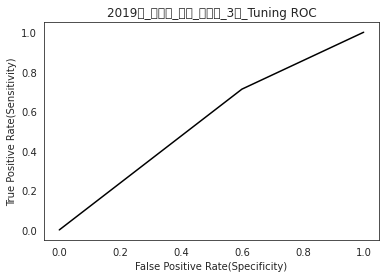

In [187]:
# Model Evaluation (AUC)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
roc_auc = metrics.auc(fpr, tpr)
print("2019년_의료비_지출_총금액_3년_Tuning AUC =", roc_auc)

# ROC
plt.title('2019년_의료비_지출_총금액_3년_Tuning ROC')
plt.xlabel('False Positive Rate(Specificity)')
plt.ylabel('True Positive Rate(Sensitivity)')
plt.plot(fpr, tpr, 'k', label=roc_auc); 

### 19.1 생활용품 지출 (1년)

In [188]:
# 생활용품_지출_총금액_3년  (2017년)

X = df_x.values
y = df_y_17.생활용품_지출_총금액_1년.values

# Train, Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

In [175]:
log_reg = LogisticRegression()

# 하이퍼파라미터 튜닝
params = {'C':list(np.concatenate([np.arange(0.01,1,0.01), np.arange(1,10,1)]))}
           
# Logistic Regression 객체 생성 후 GridSearchCV 수행
grid_log = GridSearchCV(log_reg, params, cv=5)
grid_log.fit(X_train, y_train)

print('최적 하이퍼 파라미터: ', grid_log.best_params_)
print('최고 예측 정확도: {:.4f}'.format(grid_log.best_score_))

최적 하이퍼 파라미터:  {'C': 2.0}
최고 예측 정확도: 0.6240


In [176]:
# 다시 학습 및 예측 성능 측정
lg_clf = LogisticRegression(C= 2.0,
                                n_jobs=-1,
                                random_state=18,
                                verbose=0)
lg_clf.fit(X_train, y_train)
y_pred = lg_clf.predict(X_test)
print('예측 정확도: {:.4f}'.format(accuracy_score(y_test,y_pred)))

예측 정확도: 0.5941


2017년 지출 총금액_Tuning AUC = 0.5124069478908189


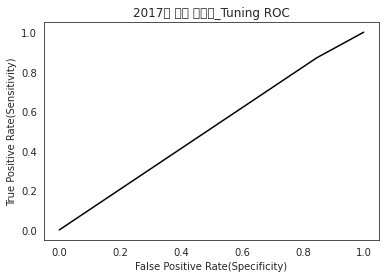

In [177]:
# Model Evaluation (AUC)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
roc_auc = metrics.auc(fpr, tpr)
print("2017년 지출 총금액_Tuning AUC =", roc_auc)

# ROC
plt.title('2017년 지출 총금액_Tuning ROC')
plt.xlabel('False Positive Rate(Specificity)')
plt.ylabel('True Positive Rate(Sensitivity)')
plt.plot(fpr, tpr, 'k', label=roc_auc); 

### 19.2 생활용출 지출 (3년)

In [189]:
# 거주 세대 수  (2017년)

X = df_x.values
y = df_y_19.생활용품_지출_총금액_3년.values

# Train, Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

In [190]:
#객체생성 
xgb = XGBClassifier(random_state=18)

# 하이퍼파라미터 튜닝
params = {
    'learning_rate': list(np.concatenate([np.arange(1,11)/100, np.arange(2,11)/10, np.arange(2,11)])), 'n_estimators': list(range(100, 400,  100)),
    'n_iter': list(range(100, 1000, 100)),
    'max_depth': list(range(4, 20)),
    }
           
# XGBClassifier 객체 생성 후 GridSearchCV 수행
grid_xgb = GridSearchCV(xgb, param_grid = params, n_jobs = -1, verbose=1, scoring='roc_auc')
grid_xgb.fit(X_train, y_train)

print('최적 하이퍼 파라미터: ', grid_xgb.best_params_)
print('최고 예측 정확도: {:.4f}'.format(grid_xgb.best_score_))

Fitting 5 folds for each of 12096 candidates, totalling 60480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 648 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 3200 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 6800 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 11200 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done 16400 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done 22400 tasks      | elapsed:   20.9s
[Parallel(n_jobs=-1)]: Done 29200 tasks      | elapsed:   25.8s
[Parallel(n_jobs=-1)]: Done 36800 tasks      | elapsed:   30.5s
[Parallel(n_jobs=-1)]: Done 45200 tasks      | elapsed:   34.9s
[Parallel(n_jobs=-1)]: Done 54400 tasks      | elapsed:   38.9s


[14:24:08] WARNING: ../src/learner.cc:516: 
Parameters: { n_iter } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


최적 하이퍼 파라미터:  {'learning_rate': 2.0, 'max_depth': 8, 'n_estimators': 200, 'n_iter': 100}
최고 예측 정확도: 0.7058


[Parallel(n_jobs=-1)]: Done 60480 out of 60480 | elapsed:   41.1s finished


In [193]:
xgb1= XGBClassifier(n_estimators = 200, 
                    max_depth = 10,
                    n_iter = 100,
                    learning_rate = 2.0,
                    random_state = 18,
                    n_jobs = -1
                    )
xgb1.fit(X_train, y_train)
y_pred = xgb1.predict(X_test)
print('예측 정확도: {:.4f}'.format(accuracy_score(y_test,y_pred)))

[14:24:40] WARNING: ../src/learner.cc:516: 
Parameters: { n_iter } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


예측 정확도: 0.6733


2019년_생활용품_지출_총금액__Tuning AUC = 0.6158008658008658


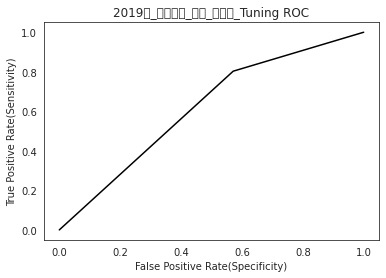

In [194]:
# Model Evaluation (AUC)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
roc_auc = metrics.auc(fpr, tpr)
print("2019년_생활용품_지출_총금액__Tuning AUC =", roc_auc)

# ROC
plt.title('2019년_생활용품_지출_총금액_Tuning ROC')
plt.xlabel('False Positive Rate(Specificity)')
plt.ylabel('True Positive Rate(Sensitivity)')
plt.plot(fpr, tpr, 'k', label=roc_auc); 

### 20.1 여가 지출 (1년)

In [195]:
# 여가_지출_총금액_1년  (2017년)

X = df_x.values
y = df_y_17.여가_지출_총금액_1년.values

# Train, Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

In [196]:
# 하이퍼파라미터 튜닝
from sklearn.model_selection import GridSearchCV

params = {'n_estimators' :[300,400,500],
           'max_depth' : list(range(4, 20)),
           'criterion' : ['gini', 'entropy']
           }

# RandomForestClassifier 객체 생성 후 GridSearchCV 수행
rf_clf = RandomForestClassifier(random_state = 0, n_jobs = -1)
grid_cv = GridSearchCV(rf_clf, param_grid = params, scoring='roc_auc', cv = 5, n_jobs = -1)
grid_cv.fit(X_train, y_train)

print('최적 하이퍼 파라미터: ', grid_cv.best_params_)

최적 하이퍼 파라미터:  {'criterion': 'entropy', 'max_depth': 17, 'n_estimators': 400}


In [197]:
# 다시 학습 및 예측 성능 측정
rf_clf1 = RandomForestClassifier(n_estimators = 400, 
                                max_depth = 17,
                                random_state = 1,
                                criterion = 'entropy')
rf_clf1.fit(X_train, y_train)
y_pred = rf_clf1.predict(X_test)
print('예측 정확도: {:.4f}'.format(accuracy_score(y_test,y_pred)))

예측 정확도: 0.5248


2017년_여가_지출_총금액_Tuning AUC = 0.4749793217535153


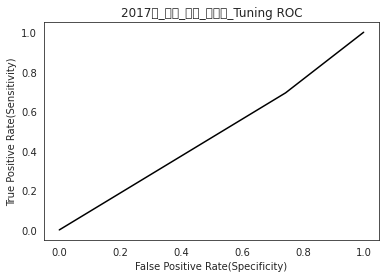

In [198]:
# Model Evaluation (AUC)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
roc_auc = metrics.auc(fpr, tpr)
print("2017년_여가_지출_총금액_Tuning AUC =", roc_auc)

# ROC
plt.title('2017년_여가_지출_총금액_Tuning ROC')
plt.xlabel('False Positive Rate(Specificity)')
plt.ylabel('True Positive Rate(Sensitivity)')
plt.plot(fpr, tpr, 'k', label=roc_auc); 

### 20.2 여가 지출 (3년)

In [199]:
# 여가_지출_총금액_3년  (2019년)

X = df_x.values
y = df_y_19.여가_지출_총금액_3년.values

# Train, Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

In [200]:
#객체생성 
xgb = XGBClassifier(random_state=18)

# 하이퍼파라미터 튜닝
params = {
    'learning_rate': list(np.concatenate([np.arange(1,11)/100, np.arange(2,11)/10, np.arange(2,11)])), 'n_estimators': list(range(100, 400,  100)),
    'n_iter': list(range(100, 1000, 100)),
    'max_depth': list(range(4, 20)),
    }
           
# XGBClassifier 객체 생성 후 GridSearchCV 수행
grid_xgb = GridSearchCV(xgb, param_grid = params, n_jobs = -1, verbose=1, scoring='roc_auc')
grid_xgb.fit(X_train, y_train)

print('최적 하이퍼 파라미터: ', grid_xgb.best_params_)
print('최고 예측 정확도: {:.4f}'.format(grid_xgb.best_score_))

Fitting 5 folds for each of 12096 candidates, totalling 60480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 648 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 2048 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 3848 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 6048 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 8648 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done 11648 tasks      | elapsed:   12.0s
[Parallel(n_jobs=-1)]: Done 15048 tasks      | elapsed:   15.3s
[Parallel(n_jobs=-1)]: Done 18848 tasks      | elapsed:   18.8s
[Parallel(n_jobs=-1)]: Done 23048 tasks      | elapsed:   22.3s
[Parallel(n_jobs=-1)]: Done 27648 tasks      | elapsed:   25.7s
[Parallel(n_jobs=-1)]: Done 32648 tasks      | elapsed:   29.2s
[Parallel(n_jobs=-1)]: Done 38592 tasks      | elapsed:   33.0s
[Parallel(n_jobs=-1)]: Done 50192 tasks      | elapsed:   38.4s
[Parallel(n_jobs=-1)]: Done 60352 t

[14:26:08] WARNING: ../src/learner.cc:516: 
Parameters: { n_iter } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


최적 하이퍼 파라미터:  {'learning_rate': 0.8, 'max_depth': 5, 'n_estimators': 200, 'n_iter': 100}
최고 예측 정확도: 0.7074


In [201]:
xgb1= XGBClassifier(n_estimators = 200, 
                    max_depth = 6,
                    n_iter = 100,
                    learning_rate = 0.8,
                    random_state = 18,
                    n_jobs = -1
                    )
xgb1.fit(X_train, y_train)
y_pred = xgb1.predict(X_test)
print('예측 정확도: {:.4f}'.format(accuracy_score(y_test,y_pred)))

[14:26:28] WARNING: ../src/learner.cc:516: 
Parameters: { n_iter } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


예측 정확도: 0.6634


2019년_여가_지출_총금액_Tuning AUC = 0.6352459016393442


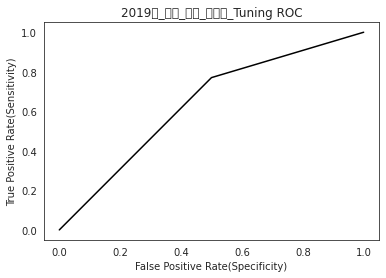

In [202]:
# Model Evaluation (AUC)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
roc_auc = metrics.auc(fpr, tpr)
print("2019년_여가_지출_총금액_Tuning AUC =", roc_auc)

# ROC
plt.title('2019년_여가_지출_총금액_Tuning ROC')
plt.xlabel('False Positive Rate(Specificity)')
plt.ylabel('True Positive Rate(Sensitivity)')
plt.plot(fpr, tpr, 'k', label=roc_auc); 

### 21.1 식료품 지출 (1년)

In [203]:
# 식료품_지출_총금액_1년  (2017년)

X = df_x.values
y = df_y_17.식료품_지출_총금액_1년.values

# Train, Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

In [204]:
#객체생성 
xgb = XGBClassifier(random_state=18)

# 하이퍼파라미터 튜닝
params = {
    'learning_rate': list(np.concatenate([np.arange(1,11)/100, np.arange(2,11)/10, np.arange(2,11)])), 'n_estimators': list(range(100, 400,  100)),
    'n_iter': list(range(100, 1000, 100)),
    'max_depth': list(range(4, 20)),
    }
           
# XGBClassifier 객체 생성 후 GridSearchCV 수행
grid_xgb = GridSearchCV(xgb, param_grid = params, n_jobs = -1, verbose=1, scoring='roc_auc')
grid_xgb.fit(X_train, y_train)

print('최적 하이퍼 파라미터: ', grid_xgb.best_params_)
print('최고 예측 정확도: {:.4f}'.format(grid_xgb.best_score_))

Fitting 5 folds for each of 12096 candidates, totalling 60480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 648 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 3200 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 6800 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 11200 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done 16400 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done 22400 tasks      | elapsed:   21.0s
[Parallel(n_jobs=-1)]: Done 29200 tasks      | elapsed:   26.2s
[Parallel(n_jobs=-1)]: Done 36800 tasks      | elapsed:   30.9s
[Parallel(n_jobs=-1)]: Done 45200 tasks      | elapsed:   35.2s
[Parallel(n_jobs=-1)]: Done 54400 tasks      | elapsed:   39.4s


[14:27:23] WARNING: ../src/learner.cc:516: 
Parameters: { n_iter } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


최적 하이퍼 파라미터:  {'learning_rate': 1.0, 'max_depth': 9, 'n_estimators': 200, 'n_iter': 100}
최고 예측 정확도: 0.7267


[Parallel(n_jobs=-1)]: Done 60480 out of 60480 | elapsed:   41.7s finished


In [205]:
xgb1= XGBClassifier(n_estimators = 200, 
                    max_depth = 9,
                    n_iter = 100,
                    learning_rate = 1.0 ,
                    random_state = 18,
                    n_jobs = -1
                    )
xgb1.fit(X_train, y_train)
y_pred = xgb1.predict(X_test)
print('예측 정확도: {:.4f}'.format(accuracy_score(y_test,y_pred)))

[14:27:42] WARNING: ../src/learner.cc:516: 
Parameters: { n_iter } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


예측 정확도: 0.5644


2017년_식료품_지출_총금액_Tuning AUC = 0.5357733664185277


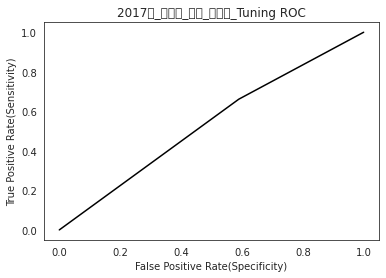

In [206]:
# Model Evaluation (AUC)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
roc_auc = metrics.auc(fpr, tpr)
print("2017년_식료품_지출_총금액_Tuning AUC =", roc_auc)

# ROC
plt.title('2017년_식료품_지출_총금액_Tuning ROC')
plt.xlabel('False Positive Rate(Specificity)')
plt.ylabel('True Positive Rate(Sensitivity)')
plt.plot(fpr, tpr, 'k', label=roc_auc); 

### 21.2 식료품 지출 (3년)

In [207]:
# 여가_지출_총금액_1년  (2017년)

X = df_x.values
y = df_y_19.식료품_지출_총금액_3년.values

# Train, Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

In [208]:
# 하이퍼파라미터 튜닝
from sklearn.model_selection import GridSearchCV

params = {'n_estimators' :[300,400,500],
           'max_depth' : list(range(4, 20)),
           'criterion' : ['gini', 'entropy']
           }

# RandomForestClassifier 객체 생성 후 GridSearchCV 수행
rf_clf = RandomForestClassifier(random_state = 0, n_jobs = -1)
grid_cv = GridSearchCV(rf_clf, param_grid = params, scoring='roc_auc', cv = 5, n_jobs = -1)
grid_cv.fit(X_train, y_train)

print('최적 하이퍼 파라미터: ', grid_cv.best_params_)

최적 하이퍼 파라미터:  {'criterion': 'entropy', 'max_depth': 6, 'n_estimators': 300}


In [209]:
# 다시 학습 및 예측 성능 측정
rf_clf1 = RandomForestClassifier(n_estimators = 300, 
                                max_depth = 6,
                                random_state = 1,
                                criterion = 'entropy')
rf_clf1.fit(X_train, y_train)
y_pred = rf_clf1.predict(X_test)
print('예측 정확도: {:.4f}'.format(accuracy_score(y_test,y_pred)))

예측 정확도: 0.6436


2019년_식료품_지출_총금액_Tuning AUC = 0.49353832442067735


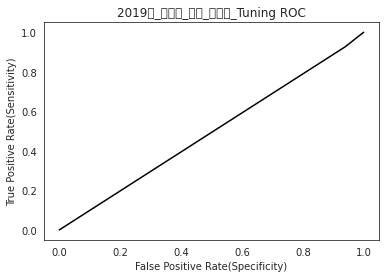

In [210]:
# Model Evaluation (AUC)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
roc_auc = metrics.auc(fpr, tpr)
print("2019년_식료품_지출_총금액_Tuning AUC =", roc_auc)

# ROC
plt.title('2019년_식료품_지출_총금액_Tuning ROC')
plt.xlabel('False Positive Rate(Specificity)')
plt.ylabel('True Positive Rate(Sensitivity)')
plt.plot(fpr, tpr, 'k', label=roc_auc); 